In [1]:
import torch, os, math, platform, random, copy, json
from math import floor
import torch._dynamo
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from torch.optim import AdamW
from typing import Optional, Tuple, Union
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from torch.utils.data import random_split
from torch.amp import autocast, GradScaler

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())      # Should be True
print(torch.cuda.get_device_name(0))

2.5.1+cu124
True
NVIDIA GeForce RTX 4090


In [3]:
file_paths = {
    "GreenhouseClimate": "/home/cuongdo/IUACAAS/GreenhouseClimate.csv",
    "GrodanSens": "/home/cuongdo/IUACAAS/GrodanSens.csv",
    "Resources": "/home/cuongdo/IUACAAS/Resources.csv",
    "Weather": "/home/cuongdo/Weather/Weather.csv",
    "CropParameters": "/home/cuongdo/IUACAAS/CropParameters.csv"
}

In [4]:
soil_cols = ['EC_slab1','EC_slab2','WC_slab1','WC_slab2','t_slab1','t_slab2']
indoor_cols = ['Tair','Rhair','HumDef','CO2air','PipeLow','VentLee','Ventwind','EC_drain_PC']
weather_cols = ['Tout','Rhout','Iglob','PARout','Pyrgeo','Rain','Windsp']
crop_cols = ['plant_dens','stem_dens','Cum_trusses','Stem_elong','Stem_thick']

In [5]:
dfs = {}
for name, path in file_paths.items():
    df = pd.read_csv(path, low_memory=False)
    df.columns = df.columns.str.strip().str.replace('\t', '', regex=False)
    # unify/derive datetime column -> Date
    if '%time' in df.columns or '%Time' in df.columns:
        tcol = '%time' if '%time' in df.columns else '%Time'
        df[tcol] = pd.to_numeric(df[tcol], errors='coerce')
        df['Date'] = pd.to_datetime(df[tcol], origin='1899-12-30', unit='D', errors='coerce')
    elif 'time' in df.columns:
        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        df['Date'] = pd.to_datetime(df['time'], origin='1899-12-30', unit='D', errors='coerce')
    elif 'Date' in df.columns:
        if pd.api.types.is_numeric_dtype(df['Date']):
            df['Date'] = pd.to_datetime(df['Date'], origin='1899-12-30', unit='D', errors='coerce')
        else:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    else:
        df['Date'] = pd.NaT
    # numeric coercion (keep Date intact)
    num_cols = [c for c in df.columns if c != 'Date']
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Date'])
    # cadence & aggregation
    if name in ('GreenhouseClimate', 'GrodanSens', 'Weather'):
        # 5-min streams → use FLOOR (never push into next day)
        df['Date'] = df['Date'].dt.floor('5min')
        df = df.groupby('Date', as_index=False).mean(numeric_only=True)
    elif name == 'Resources':
        # daily already; ensure unique per day via mean (robust vs duplicates)
        df['Date'] = df['Date'].dt.floor('D')
        df = (df.groupby('Date', as_index=False)
                .agg({c:'mean' for c in df.columns if c!='Date'}))
    elif name == 'CropParameters':
        # weekly/sparse; make daily grid later and ffill
        df['Date'] = df['Date'].dt.floor('D')
        df = df.groupby('Date', as_index=False).mean(numeric_only=True)
    dfs[name] = df.sort_values('Date').reset_index(drop=True)

In [6]:
def pick_cols(df: pd.DataFrame, want: list[str]) -> list[str]:
    return [c for c in want if c in df.columns]

soil_keep    = pick_cols(dfs['GrodanSens'],        soil_cols)
indoor_keep  = pick_cols(dfs['GreenhouseClimate'], indoor_cols)
weather_keep = pick_cols(dfs['Weather'],           weather_cols)
crop_keep    = pick_cols(dfs['CropParameters'],    crop_cols)

In [7]:
g5 = dfs['GrodanSens'][['Date'] + soil_keep].copy()
c5 = dfs['GreenhouseClimate'][['Date'] + indoor_keep].copy()
w5 = dfs['Weather'][['Date'] + weather_keep].copy()

In [8]:
def agg_daily_from_5min(df5: pd.DataFrame, cols: list[str], prefix: str) -> pd.DataFrame:
    """
    Aggregate 5-min streams into per-day stats for the requested columns.
    Safe merges: left_on='day' (datetime), right_index=True. Rename to Date at end.
    """
    if not cols:
        return pd.DataFrame({'Date': pd.to_datetime([])})

    tmp = df5[['Date'] + cols].copy()
    tmp['Date'] = pd.to_datetime(tmp['Date'])
    tmp['day']  = tmp['Date'].dt.floor('D')

    g = tmp.groupby('day')  # index = day (datetime64[ns])

    # Start with the day index
    out = pd.DataFrame({'day': g.size().index})

    for col in cols:
        # Means and std (as Series indexed by 'day')
        s_mean = g[col].mean()
        s_std  = g[col].std(ddof=0)

        out = out.merge(
            s_mean.rename(f'{prefix}{col}_mean'),
            left_on='day', right_index=True, how='left'
        )
        out = out.merge(
            s_std.rename(f'{prefix}{col}_std'),
            left_on='day', right_index=True, how='left'
        )

        # Quantiles as a 2-column DataFrame indexed by 'day'
        q = g[col].quantile([0.1, 0.9]).unstack()  # columns: {0.1, 0.9}
        q = q.rename(columns={0.1: f'{prefix}{col}_p10', 0.9: f'{prefix}{col}_p90'})
        out = out.merge(q, left_on='day', right_index=True, how='left')

        # Amplitude (p90 - p10)
        out[f'{prefix}{col}_amp'] = out[f'{prefix}{col}_p90'] - out[f'{prefix}{col}_p10']

        # Missingness fraction (count / 288)
        cnt = g[col].count()  # Series indexed by 'day'
        out = out.merge(cnt.rename(f'__cnt_{col}'), left_on='day', right_index=True, how='left')
        out[f'{prefix}{col}_miss'] = 1.0 - (out[f'__cnt_{col}'] / 288.0)
        out.drop(columns=[f'__cnt_{col}'], inplace=True)

    # Finalize
    out = out.sort_values('day').reset_index(drop=True)
    out = out.rename(columns={'day': 'Date'})
    return out

In [9]:
soil_day   = agg_daily_from_5min(g5, soil_keep,   'soil_')
indoor_day = agg_daily_from_5min(c5, indoor_keep, 'ind_')
weath_day  = agg_daily_from_5min(w5, weather_keep,'out_')
days_all = pd.date_range(g5['Date'].min().floor('D'), g5['Date'].max().floor('D'), freq='D')
_crop_src = dfs['CropParameters'][['Date'] + crop_keep].copy()
_crop_src['Date'] = pd.to_datetime(_crop_src['Date']).dt.floor('D')
crop_raw = (_crop_src.set_index('Date').reindex(days_all))              # true observation pattern
crop_d = (crop_raw.ffill().reset_index().rename(columns={'index':'Date'}))     # values fed to the model/merge

In [10]:
ELEC_PEAK, ELEC_OFF, HEAT_PER_MJ, AREA_M2 = 0.08, 0.04, 0.0083, 62.5
res = dfs['Resources'][['Date','ElecHigh','ElecLow','Heat_cons']].copy()
res['Date'] = pd.to_datetime(res['Date']).dt.floor('D')
# Daily kWh/MJ per m² → € per m² → € per house
res['Elec_day']     = res['ElecHigh'] + res['ElecLow']
res['Heat_day']     = res['Heat_cons']
res['elec_cost_m2'] = res['ElecHigh']*ELEC_PEAK + res['ElecLow']*ELEC_OFF
res['heat_cost_m2'] = res['Heat_day']*HEAT_PER_MJ
res['y']            = (res['elec_cost_m2'] + res['heat_cost_m2']) * AREA_M2
y_day = res[['Date','y','Elec_day','Heat_day','ElecHigh','ElecLow']].sort_values('Date').copy()
# Defensive: ensure unique columns (prevents DataFrame-when-Series bugs)
y_day = y_day.loc[:, ~y_day.columns.duplicated()]
assert y_day.columns.is_unique, f"Duplicate columns in y_day: {list(y_day.columns[y_day.columns.duplicated()])}"
# Next-day target for day-ahead prediction
y_day['y_next'] = y_day['y'].shift(-1)

In [11]:
K = 8
assert K >= 7, "Need K ≥ 7 to build y_prev7 and y_diff7."
rs = y_day.set_index('Date')
hist = pd.DataFrame({'Date': y_day['Date']})
for i in range(1, K+1):
    hist[f'y_prev{i}'] = rs['y'].shift(i).reindex(hist['Date']).values

In [12]:
daily = (
    pd.DataFrame({'Date': pd.to_datetime(y_day['Date'])})
      .merge(soil_day,   on='Date', how='left')
      .merge(indoor_day, on='Date', how='left')
      .merge(weath_day,  on='Date', how='left')
      .merge(crop_d,     on='Date', how='left')          # crop (daily)
      .merge(hist,       on='Date', how='left')          # y_prev*
      .merge(y_day[['Date','y','y_next']], on='Date', how='left')
      .sort_values('Date').reset_index(drop=True)
)
# Anchors (exactly 5)
daily['y_today'] = daily['y']
assert {'y_prev1','y_prev7'}.issubset(daily.columns), "Missing y_prev1 or y_prev7"
daily['y_diff1'] = daily['y_today'] - daily['y_prev1']
daily['y_diff7'] = daily['y_today'] - daily['y_prev7']
# Keep only rows with valid next-day target
daily = daily[np.isfinite(daily['y_next'])].reset_index(drop=True)
assert daily['Date'].is_monotonic_increasing and daily['Date'].nunique() == len(daily)

In [13]:
crop_cols    = crop_keep[:]  # crop = CropParameters only
CROP_DIM     = len(crop_cols)
ANCHOR_COLS  = ['y_today','y_prev1','y_prev7','y_diff1','y_diff7']
assert all(c in daily.columns for c in ANCHOR_COLS), f"Anchor cols missing: {[c for c in ANCHOR_COLS if c not in daily.columns]}"
ANCHOR_DIM   = 5

In [14]:
g5i = g5.set_index('Date')
c5i = c5.set_index('Date')
w5i = w5.set_index('Date')

def day_grid(d):
    d = pd.to_datetime(d).floor('D')
    return pd.date_range(d, d + pd.Timedelta(days=1) - pd.Timedelta(minutes=5), freq='5min')

def reindex_full_day(df_idx, cols, d):
    grid = day_grid(d)
    block = df_idx.reindex(grid)
    for c in cols:
        if c not in block.columns:
            block[c] = np.nan
    return block[cols].to_numpy(dtype=float, copy=False)

def steps_since_last_obs_day(mask_2d: np.ndarray) -> np.ndarray:
    T, D = mask_2d.shape
    delta = np.zeros((T, D), dtype=np.float32)
    last  = np.zeros(D, dtype=np.float32)
    for t in range(T):
        last = np.where(mask_2d[t] > 0.0, 0.0, last + 1.0)
        delta[t] = last
    np.minimum(delta, 3*288, out=delta)
    return delta

def days_since_last_obs_per_feature(X_2d: np.ndarray, max_cap: int = 365) -> np.ndarray:
    N, D = X_2d.shape
    m = np.isfinite(X_2d)
    delta = np.full((N, D), np.nan, dtype=float)
    last = np.full(D, -np.inf, dtype=float)
    for i in range(N):
        last = np.where(m[i], i, last)
        delta[i] = i - last
    return np.clip(delta, 0, max_cap).astype(np.float32)

In [15]:
soil_list, soil_mask_list, soil_delta_list = [], [], []
indoor_list, indoor_mask_list, indoor_delta_list = [], [], []
weather_list, weather_mask_list, weather_delta_list = [], [], []
crop_rows, anchor_rows = [], []
y_list, date_list = [], []

In [16]:
for d in daily['Date']:
    s  = reindex_full_day(g5i, soil_keep,   d).astype(np.float32)
    e  = reindex_full_day(c5i, indoor_keep, d).astype(np.float32)
    ww = reindex_full_day(w5i, weather_keep,d).astype(np.float32)
    sm = np.isfinite(s).astype(np.float32); sd  = steps_since_last_obs_day(sm).astype(np.float32)
    im = np.isfinite(e).astype(np.float32); idl = steps_since_last_obs_day(im).astype(np.float32)
    wm = np.isfinite(ww).astype(np.float32); wd  = steps_since_last_obs_day(wm).astype(np.float32)
    row = daily.loc[daily['Date'] == d].iloc[0]
    crop_vec   = (row[crop_cols].to_numpy(dtype=float, copy=False).astype(np.float32)
                  if CROP_DIM > 0 else np.zeros((0,), np.float32))
    anchor_vec = row[ANCHOR_COLS].to_numpy(dtype=float, copy=False).astype(np.float32)
    soil_list.append(s);     soil_mask_list.append(sm);     soil_delta_list.append(sd)
    indoor_list.append(e);   indoor_mask_list.append(im);   indoor_delta_list.append(idl)
    weather_list.append(ww); weather_mask_list.append(wm);  weather_delta_list.append(wd)
    crop_rows.append(crop_vec); anchor_rows.append(anchor_vec)
    y_list.append([float(row['y_next'])])
    date_list.append(pd.to_datetime(d))

In [17]:
# ---------- Stack to numpy ----------
soil_np      = np.stack(soil_list)         # [N,288,Ds]
soil_m_np    = np.stack(soil_mask_list)
soil_d_np    = np.stack(soil_delta_list)
indoor_np    = np.stack(indoor_list)       # [N,288,Di]
indoor_m_np  = np.stack(indoor_mask_list)
indoor_d_np  = np.stack(indoor_delta_list)
weather_np   = np.stack(weather_list)      # [N,288,Dw]
weather_m_np = np.stack(weather_mask_list)
weather_d_np = np.stack(weather_delta_list)
crop_np      = (np.vstack(crop_rows) if CROP_DIM > 0 else np.zeros((len(date_list), 0), np.float32))      # [N, CROP_DIM]
anchor_np    = np.vstack(anchor_rows).astype(np.float32)             # [N, 5]
y_np         = np.array(y_list, dtype=np.float32)                    # [N,1]
dates_all    = np.array(date_list, dtype='datetime64[ns]')

In [18]:
if CROP_DIM > 0:
    # Align the RAW (non-ffilled) grid to the exact days we kept in `daily`
    crop_raw_sel = (crop_raw
                    .reindex(pd.to_datetime(date_list))  # DatetimeIndex; same order as `daily`
                    .to_numpy(dtype=float))
    crop_mask_np  = np.isfinite(crop_raw_sel).astype(np.float32)
    crop_delta_np = days_since_last_obs_per_feature(crop_raw_sel)
else:
    crop_mask_np  = np.zeros_like(crop_np, np.float32)
    crop_delta_np = np.zeros_like(crop_np, np.float32)
# ---------- Anchor mask/delta ----------
anchor_mask_np  = np.isfinite(anchor_np).astype(np.float32)
anchor_delta_np = days_since_last_obs_per_feature(anchor_np)
# ---------- Torch tensors ----------
to_t = lambda x: torch.tensor(x, dtype=torch.float32)
soil_all = to_t(soil_np);
soil_mask   = to_t(soil_m_np);
soil_delta   = to_t(soil_d_np)
indoor_all = to_t(indoor_np);
indoor_mask = to_t(indoor_m_np);
indoor_delta = to_t(indoor_d_np)
weather_all = to_t(weather_np);
weather_mask= to_t(weather_m_np); weather_delta= to_t(weather_d_np)
crop_all = to_t(crop_np) # CROP (daily values, ffilled)
crop_mask = to_t(crop_mask_np)    # mask from RAW observation pattern
crop_delta = to_t(crop_delta_np)  # age (days since last true obs), from RAW
anchor_all = to_t(anchor_np) # ANCHOR (5 features)
anchor_mask  = to_t(anchor_mask_np) # ~1s (clean) else 0 where missing
anchor_delta = to_t(anchor_delta_np)# ~0s (clean) else days since last obs
y_all = to_t(y_np) # label = y_next

In [19]:
dates_np = np.array(dates_all, dtype='datetime64[ns]')
assert dates_np.ndim == 1 and dates_np.size > 1, f"Bad dates_all shape: {dates_np.shape}"
assert np.all(dates_np[1:] >= dates_np[:-1]), "dates_all must be non-decreasing (chronological)."

N = len(dates_np)
# --- ratios  ---
tr_frac = 0.60
va_frac = 0.20
te_frac = 1.0 - tr_frac - va_frac
assert 0 < tr_frac < 1 and 0 < va_frac < 1 and te_frac > 0, "Bad split fractions."
gap_days_tr_va = 0
gap_days_va_te = 0
i_tr_end = int(np.floor(tr_frac * N)) - 1
i_va_end = int(np.floor((tr_frac + va_frac) * N)) - 1
def advance_to_after(date_arr, start_idx, min_date):
    while start_idx < len(date_arr) and date_arr[start_idx] <= min_date:
        start_idx += 1
    return start_idx
if gap_days_tr_va > 0:
    va_start_min = dates_np[i_tr_end] + np.timedelta64(gap_days_tr_va, 'D')
    va_start_idx = advance_to_after(dates_np, i_tr_end + 1, va_start_min)
else:
    va_start_idx = i_tr_end + 1
if gap_days_va_te > 0:
    te_start_min = dates_np[i_va_end] + np.timedelta64(gap_days_va_te, 'D')
    te_start_idx = advance_to_after(dates_np, i_va_end + 1, te_start_min)
else:
    te_start_idx = i_va_end + 1
# Guardrails (ensure non-empty splits)
assert i_tr_end >= 0, "Train split too small."
assert i_va_end >= i_tr_end, "Val boundary must be after train."
assert te_start_idx < N, "Test split would be empty."
assert va_start_idx <= i_va_end, "Val split became empty after applying gaps."

In [20]:
train_ix = np.arange(0, i_tr_end + 1, dtype=int)
val_ix   = np.arange(va_start_idx, i_va_end + 1, dtype=int)
test_ix  = np.arange(te_start_idx, N, dtype=int)
# Sanity prints
print(f"[SPLIT-{int(tr_frac*100)}/{int(va_frac*100)}/{int(te_frac*100)}] N={N}")
print(f"  Train: n={len(train_ix)} | {dates_np[train_ix[0]]} → {dates_np[train_ix[-1]]}")
print(f"  Val:   n={len(val_ix)}   | {dates_np[val_ix[0]]} → {dates_np[val_ix[-1]]}")
print(f"  Test:  n={len(test_ix)}  | {dates_np[test_ix[0]]} → {dates_np[test_ix[-1]]}")

[SPLIT-60/20/20] N=165
  Train: n=99 | 2019-12-16T00:00:00.000000000 → 2020-03-23T00:00:00.000000000
  Val:   n=33   | 2020-03-24T00:00:00.000000000 → 2020-04-25T00:00:00.000000000
  Test:  n=33  | 2020-04-26T00:00:00.000000000 → 2020-05-28T00:00:00.000000000


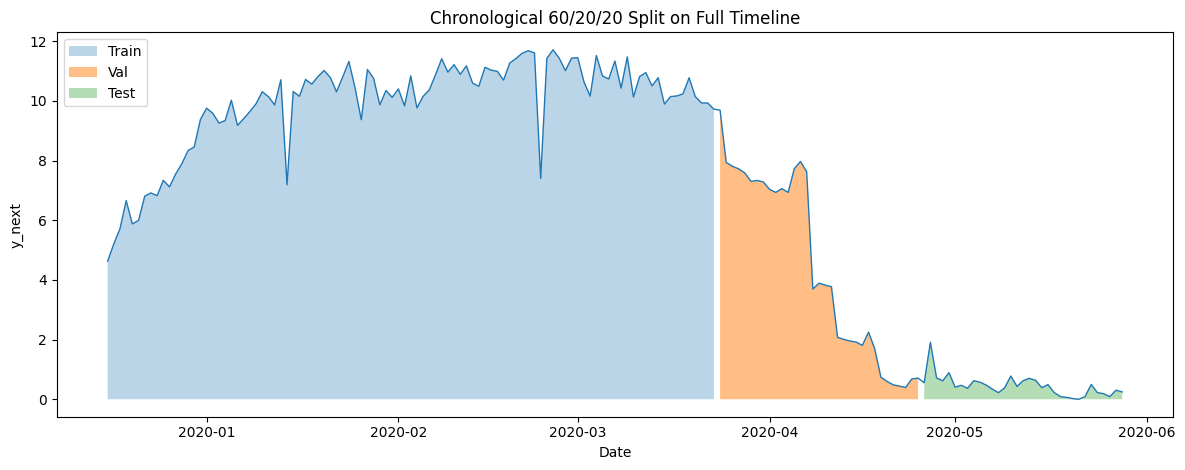

In [21]:
# Make boolean masks for the full timeline (useful for plotting/joins)
train_mask = np.zeros(N, dtype=bool); train_mask[train_ix] = True
val_mask   = np.zeros(N, dtype=bool); val_mask[val_ix]     = True
test_mask  = np.zeros(N, dtype=bool); test_mask[test_ix]   = True

# Optional: quick timeline plot to verify
y_np = y_all.detach().cpu().numpy().reshape(-1)
dates_pd = pd.to_datetime(dates_np)

plt.figure(figsize=(12, 4.8))
# Train
plt.fill_between(dates_pd, y_np, 0, where=train_mask, alpha=0.30, label="Train")
# Val
plt.fill_between(dates_pd, y_np, 0, where=val_mask,   alpha=0.50, label="Val")
# Test
plt.fill_between(dates_pd, y_np, 0, where=test_mask,  alpha=0.35, label="Test")
# Target curve
plt.plot(dates_pd, y_np, linewidth=1.0, zorder=3)

plt.title("Chronological 60/20/20 Split on Full Timeline")
plt.xlabel("Date"); plt.ylabel("y_next")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [22]:
# ---------- GPU & pin helpers ----------
def _is_cuda_device(dev) -> bool:
    if isinstance(dev, torch.device):
        return dev.type == "cuda"
    if isinstance(dev, str):
        return dev.lower().startswith("cuda")
    return str(dev).lower().startswith("cuda")

def _assert_cuda_4090(device) -> None:
    """Hard guard: ensure we're on an RTX 4090."""
    if not _is_cuda_device(device):
        raise AssertionError(f"Expected CUDA device, got {device!r}")
    dev = torch.device(device) if not isinstance(device, torch.device) else device
    idx = dev.index if dev.index is not None else torch.cuda.current_device()
    name = torch.cuda.get_device_name(idx)
    if "4090" not in name and "RTX 4090" not in name:
        raise AssertionError(f"Expected RTX 4090, got '{name}' at cuda:{idx}")

class _CudaPrefetcher:
    def __init__(self, loader: DataLoader, device: torch.device | str):
        self.loader = loader
        self.device = torch.device(device) if not isinstance(device, torch.device) else device
        self.stream = torch.cuda.Stream(device=self.device)

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        it = iter(self.loader)
        next_batch = None

        def _to_cuda(batch):
            out = []
            for t in batch:
                out.append(t.to(self.device, non_blocking=True) if isinstance(t, torch.Tensor) else t)
            return out

        # prefetch first
        with torch.cuda.stream(self.stream):
            try:
                next_batch = _to_cuda(next(it))
            except StopIteration:
                next_batch = None

        while next_batch is not None:
            torch.cuda.current_stream(self.device).wait_stream(self.stream)
            batch = next_batch

            # prefetch next
            with torch.cuda.stream(self.stream):
                try:
                    next_batch = _to_cuda(next(it))
                except StopIteration:
                    next_batch = None

            yield batch

# ---------- your original helpers ----------
def _as_cpu_indices(ix, N: int, allow_empty: bool = False) -> torch.Tensor:
    if isinstance(ix, np.ndarray):
        if ix.dtype == np.bool_:
            assert ix.shape[0] == N, f"bool mask len {ix.shape[0]} != N={N}"
            ix = np.nonzero(ix)[0]
        ix = torch.from_numpy(ix)
    elif isinstance(ix, torch.Tensor):
        ix = ix.detach().cpu()
        if ix.dtype == torch.bool:
            assert ix.numel() == N, f"bool mask len {ix.numel()} != N={N}"
            ix = ix.nonzero(as_tuple=False).squeeze(1)
    else:
        if isinstance(ix, (list, tuple)):
            ix = torch.tensor(ix, dtype=torch.long)
        elif isinstance(ix, (int, np.integer)):
            ix = torch.tensor([int(ix)], dtype=torch.long)
        else:
            raise TypeError(f"Unsupported index type: {type(ix)}")

    ix = ix.to(torch.long).view(-1)
    if ix.numel() == 0:
        assert allow_empty, "empty index set"
        return ix

    mn, mx = int(ix.min()), int(ix.max())
    assert 0 <= mn <= mx < N, f"index out of range: min={mn}, max={mx}, N={N}"
    return ix

def _nanmean_std(x: torch.Tensor, dim=0, eps: float = 1e-6, keepdim: bool = False):
    finite = torch.isfinite(x)
    x0 = torch.where(finite, x, torch.zeros_like(x))
    cnt = finite.sum(dim=dim, keepdim=True).clamp_min(1)
    mean = x0.sum(dim=dim, keepdim=True) / cnt
    var = torch.where(finite, (x0 - mean) ** 2, torch.zeros_like(x0)).sum(dim=dim, keepdim=True) / cnt
    std = torch.sqrt(var + eps)
    if not keepdim:
        mean = mean.squeeze(dim)
        std  = std.squeeze(dim)
    return mean, std.clamp_min(eps)

def _fit_fold_scaler(core_cpu: torch.Tensor, ix_cpu: torch.Tensor | None, eps: float = 1e-6):
    x = core_cpu if (ix_cpu is None or ix_cpu.numel() == 0) else core_cpu[ix_cpu]
    mu, std = _nanmean_std(x, dim=0, eps=eps)
    mu = torch.nan_to_num(mu, nan=0.0)
    std = torch.nan_to_num(std, nan=1.0).clamp_min(eps)
    return mu, std

# ---------- make_loader with strict 4090 check + correct pinning ----------
def make_loader(ix,
                shuffle: bool,
                *,
                data: dict,
                scale: dict | None,
                device: torch.device | str = torch.device("cuda:0"),
                batch_size: int | None = None,
                prefer_full_batch: bool = False,
                num_workers: int = 0,
                crop_dim: int | None = None,
                return_prefetcher: bool = False):
    """
    Returns a CPU DataLoader with pinned memory (best practice) and, optionally, a CUDA
    prefetching wrapper that yields GPU tensors (set return_prefetcher=True and then remove
    your train-loop to_device() copies).
    """
    # --- enforce RTX 4090 target (as requested) ---
    _assert_cuda_4090(device)

    # --- unpack (same as yours) ---
    soil_all    = data["soil_all"];     soil_mask   = data["soil_mask"];     soil_delta   = data["soil_delta"]
    indoor_all  = data["indoor_all"];   indoor_mask = data["indoor_mask"];   indoor_delta = data["indoor_delta"]
    weather_all = data["weather_all"];  weather_mask= data["weather_mask"];  weather_delta= data["weather_delta"]

    crop_all    = data["crop_all"];     crop_mask   = data["crop_mask"];     crop_delta   = data["crop_delta"]
    anchor_all  = data["anchor_all"];   anchor_mask = data["anchor_mask"];   anchor_delta = data["anchor_delta"]

    y_all       = data["y_all"]

    # --- move masters to CPU for safe indexing/scaler fit ---
    to_cpu = lambda t: t if t.device.type == "cpu" else t.detach().cpu()
    soil_all, soil_mask, soil_delta         = map(to_cpu, (soil_all, soil_mask, soil_delta))
    indoor_all, indoor_mask, indoor_delta   = map(to_cpu, (indoor_all, indoor_mask, indoor_delta))
    weather_all, weather_mask, weather_delta= map(to_cpu, (weather_all, weather_mask, weather_delta))
    crop_all, crop_mask, crop_delta         = map(to_cpu, (crop_all, crop_mask, crop_delta))
    anchor_all, anchor_mask, anchor_delta   = map(to_cpu, (anchor_all, anchor_mask, anchor_delta))
    y_all = to_cpu(y_all)

    # --- checks (unchanged) ---
    N = int(soil_all.size(0))
    assert all(int(t.size(0)) == N for t in [
        soil_mask, soil_delta, indoor_all, indoor_mask, indoor_delta,
        weather_all, weather_mask, weather_delta,
        crop_all, crop_mask, crop_delta,
        anchor_all, anchor_mask, anchor_delta, y_all
    ]), "size(0) mismatch"
    assert soil_all.shape    == soil_mask.shape    == soil_delta.shape,    "soil shape mismatch"
    assert indoor_all.shape  == indoor_mask.shape  == indoor_delta.shape,  "indoor shape mismatch"
    assert weather_all.shape == weather_mask.shape == weather_delta.shape, "weather shape mismatch"
    assert crop_all.dim()==2 and crop_mask.shape==crop_all.shape and crop_delta.shape==crop_all.shape, "crop dims mismatch"
    assert anchor_all.dim()==2 and anchor_mask.shape==anchor_all.shape and anchor_delta.shape==anchor_all.shape, "anchor dims mismatch"
    assert int(anchor_all.size(1)) == 5, "anchors must be [y_today, y_prev1, y_prev7, y_diff1, y_diff7] (5 cols)"

    # --- indices & crop z-scale ---
    ix_cpu = _as_cpu_indices(ix, N, allow_empty=True)

    D_crop = int(crop_all.size(1))
    crop_d = D_crop if crop_dim is None else int(crop_dim)
    assert crop_d == D_crop, f"crop_dim mismatch: {crop_d} vs {D_crop}"

    if scale is None:
        scale = {"mu": None, "std": None}
    need_fit = (scale["mu"] is None) or (scale["std"] is None) \
               or (scale["mu"].numel() != crop_d) or (scale["std"].numel() != crop_d)

    crop_cpu = crop_all[:, :crop_d].clone()
    if shuffle or need_fit:
        mu, std = _fit_fold_scaler(crop_cpu, ix_cpu)
        scale["mu"], scale["std"] = mu, std
    else:
        mu, std = scale["mu"], scale["std"]
        mu  = torch.nan_to_num(mu,  nan=0.0)
        std = torch.nan_to_num(std, nan=1.0).clamp_min(1e-6)

    crop_z = torch.nan_to_num((crop_cpu - mu) / std, nan=0.0, posinf=0.0, neginf=0.0)

    # --- select split ---
    def _sel(x): return x[ix_cpu] if ix_cpu.numel() > 0 else x[:0].clone()

    parts = [
        _sel(soil_all),    _sel(soil_mask),    _sel(soil_delta),
        _sel(indoor_all),  _sel(indoor_mask),  _sel(indoor_delta),
        _sel(weather_all), _sel(weather_mask), _sel(weather_delta),

        _sel(crop_z),      _sel(crop_mask),    _sel(crop_delta),
        _sel(anchor_all),  _sel(anchor_mask),  _sel(anchor_delta),

        _sel(y_all),
    ]
    ds = TensorDataset(*parts)

    # --- batch size ---
    if batch_size is None:
        bs = max(1, min(len(ix_cpu), 64)) if shuffle else max(1, min(len(ix_cpu), 256))
    else:
        bs = (len(ix_cpu) if (prefer_full_batch and len(ix_cpu) > 0)
              else min(max(1, batch_size), max(1, len(ix_cpu))))

    # --- pinned host loader (correct pin flag for any 'cuda:*') ---
    pin = _is_cuda_device(device)
    loader = DataLoader(
        ds,
        batch_size=bs,
        shuffle=shuffle,
        drop_last=False,
        num_workers=int(num_workers),
        pin_memory=pin,
        **({"persistent_workers": True, "prefetch_factor": 2} if num_workers and num_workers > 0 else {})
    )

    # By default keep your current training loop behavior (explicit to_device()).
    # If you want batches already on GPU from the loader, set return_prefetcher=True
    # AND remove your to_device(...) call in the loop.
    if return_prefetcher:
        return _CudaPrefetcher(loader, device)
    return loader


# Model

In [23]:
class GRUD(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int | None = None,
        *,
        include_mask: bool = True,
        include_delta: bool = True,
        dropout: float = 0.0,
        use_layernorm: bool = False,
    ):
        super().__init__()
        self.D = int(input_dim)
        self.H = int(hidden_dim)
        self.include_mask = bool(include_mask)
        self.include_delta = bool(include_delta)

        # ----- Learnable decay parameters (per feature / per hidden) -----
        # γ_x = exp(-ReLU(w_x * Δ + b_x)) ∈ (0,1]
        self.wx = nn.Parameter(torch.full((self.D,), 0.1))
        self.bx = nn.Parameter(torch.zeros(self.D))
        # γ_h = exp(-ReLU(w_h * δ + b_h)) ∈ (0,1]
        self.wh = nn.Parameter(torch.full((self.H,), 0.1))
        self.bh = nn.Parameter(torch.zeros(self.H))

        # ----- GRU over concatenated inputs -----
        gru_in = self.D \
                 + (self.D if self.include_mask else 0) \
                 + (self.D if self.include_delta else 0)
        self.gru = nn.GRUCell(gru_in, self.H)

        # Optional head
        self.dropout = nn.Dropout(dropout) if (dropout and output_dim is not None) else nn.Identity()
        if output_dim is None:
            self.out = nn.Identity()
        else:
            if use_layernorm:
                self.out = nn.Sequential(nn.LayerNorm(self.H), self.dropout, nn.Linear(self.H, output_dim))
            else:
                self.out = nn.Sequential(self.dropout, nn.Linear(self.H, output_dim))

        # Optional global mean (can be set from data) — stored as buffer
        self.register_buffer("x_global_mean", torch.zeros(1, 1, self.D))

    @torch.no_grad()
    def set_global_mean(self, mean_vec: torch.Tensor):
        """mean_vec: [D] or [1,D] or [B,1,D] -> stored as [1,1,D]."""
        mv = mean_vec.view(1, -1) if mean_vec.dim() == 1 else mean_vec
        self.x_global_mean = mv.view(1, 1, -1)

    # -------------------------- utilities --------------------------
    @staticmethod
    def _coerce_mask(mask: torch.Tensor, B: int, T: int, D: int) -> torch.Tensor:
        # Accept [B,T,D] or [B,T] or [B,T,1]; return [B,T,D] in [0,1]
        if mask.dim() == 2:
            mask = mask.unsqueeze(-1).expand(B, T, D)
        elif mask.dim() == 3 and mask.size(-1) == 1:
            mask = mask.expand(B, T, D)
        return torch.nan_to_num(mask, nan=0.0).clamp(0.0, 1.0)

    @staticmethod
    def _expand_delta(delta: torch.Tensor, D: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns (Δ_x:[B,T,D], δ_h:[B,T,1]).
        Accept delta [B,T,D] or [B,T]; nonnegative is expected.
        """
        if delta.dim() == 2:
            d_x = delta.unsqueeze(-1).expand(-1, -1, D)
            d_h = delta.unsqueeze(-1)  # [B,T,1]
        elif delta.dim() == 3 and delta.size(-1) == D:
            d_x = delta
            # scalar per step for hidden decay: average across features
            d_h = delta.mean(dim=-1, keepdim=True)
        else:
            raise ValueError(f"delta must be [B,T] or [B,T,{D}]")
        d_x = torch.nan_to_num(d_x, nan=0.0).clamp_min(0.0)
        d_h = torch.nan_to_num(d_h, nan=0.0).clamp_min(0.0)
        return d_x, d_h

    # ===== DEVICE/DTYPE-SAFE decays (borrow delta's device/dtype) =====
    def _gamma_x(self, delta_x: torch.Tensor) -> torch.Tensor:
        """Per-feature decay γ_x = exp(-ReLU(w_x * Δ + b_x)) with shape [B,T,D]."""
        wx = self.wx.to(device=delta_x.device, dtype=delta_x.dtype)
        bx = self.bx.to(device=delta_x.device, dtype=delta_x.dtype)
        gx = torch.exp(-F.relu(delta_x * wx.view(1, 1, -1) + bx.view(1, 1, -1)))
        return gx.clamp_min(1e-6).clamp_max(1.0)

    def _gamma_h(self, delta_h: torch.Tensor) -> torch.Tensor:
        """Per-hidden decay γ_h = exp(-ReLU(w_h * δ + b_h)) with shape [B,T,H]."""
        wh = self.wh.to(device=delta_h.device, dtype=delta_h.dtype)
        bh = self.bh.to(device=delta_h.device, dtype=delta_h.dtype)
        gh = torch.exp(-F.relu(delta_h * wh.view(1, 1, -1) + bh.view(1, 1, -1)))
        return gh.clamp_min(1e-6).clamp_max(1.0)

    # ----------------------------- forward -----------------------------
    def forward(
        self,
        x: torch.Tensor,          # [B,T,D]
        mask: torch.Tensor | None,# [B,T,D] or [B,T] or [B,T,1]  (1=observed)
        delta: torch.Tensor,      # [B,T,D] or [B,T]             (>=0)
        *,
        x_mean: torch.Tensor | None = None,  # [1,D] or [B,1,D]; optional
        return_seq: bool = True,             # return full H as second output
    ) -> tuple[torch.Tensor, torch.Tensor]:

        B, T, D = x.shape
        assert D == self.D, f"input_dim mismatch: expected {self.D}, got {D}"

        # ===== DEVICE/DTYPE COERCE at entry =====
        dev, dt = x.device, x.dtype
        if mask is not None:
            mask = mask.to(dev, dtype=dt)
        delta = delta.to(dev, dtype=dt)
        if (self.x_global_mean is not None) and (
            self.x_global_mean.device != dev or self.x_global_mean.dtype != dt
        ):
            self.x_global_mean = self.x_global_mean.to(dev, dtype=dt)

        # Sanitize inputs
        x_f = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

        # Mask to [B,T,D]
        if mask is None:
            m = torch.isfinite(x).to(dt)
            m = self._coerce_mask(m, B, T, D)
        else:
            m = self._coerce_mask(mask, B, T, D)

        # Deltas
        d_x, d_h = self._expand_delta(delta, D)  # [B,T,D], [B,T,1]

        # Global/batch fallback mean μ: prefer provided, else module buffer, else batch estimate
        if x_mean is not None:
            μ = x_mean.view(1, 1, D).expand(B, 1, D) if x_mean.dim() == 2 else x_mean
        elif (self.x_global_mean is not None) and (self.x_global_mean.numel() == D):
            μ = self.x_global_mean.expand(B, 1, D)  # [B,1,D]
        else:
            # Estimate from first k steps (observed entries only)
            k = min(6, T)
            x0 = torch.nan_to_num(x_f[:, :k, :], nan=0.0)
            m0 = m[:, :k, :]
            num = (x0 * m0).sum(dim=1)                # [B,D]
            den = m0.sum(dim=1).clamp_min(1.0)       # [B,D]
            μ = (num / den).unsqueeze(1)             # [B,1,D]
        μ = torch.nan_to_num(μ, nan=0.0).to(dev, dtype=dt)

        # Decays
        gamma_x = self._gamma_x(d_x)                 # [B,T,D]
        gamma_h = self._gamma_h(d_h)                 # [B,T,H]

        # Iterate
        x_prev = μ.squeeze(1).clone()                # [B,D]
        h = x_f.new_zeros(B, self.H)                 # [B,H]
        H_seq = []

        for t in range(T):
            # Input imputation with feature decay
            m_t = m[:, t, :]                         # [B,D]
            x_obs_t = torch.where(m_t > 0, x_f[:, t, :], torch.zeros_like(x_f[:, t, :]))
            xf_t = gamma_x[:, t, :] * x_prev + (1.0 - gamma_x[:, t, :]) * μ[:, 0, :]
            x_tilde = m_t * x_obs_t + (1.0 - m_t) * xf_t  # [B,D]

            # Hidden decay
            h = h * gamma_h[:, t, :]                 # [B,H]

            # Compose GRU input
            parts = [x_tilde]
            if self.include_mask:
                parts.append(m_t)
            if self.include_delta:
                parts.append(d_x[:, t, :])
            gru_in = torch.cat(parts, dim=-1)        # [B, D(+D)(+D)]

            # GRU update
            h = self.gru(gru_in, h)

            # Update x_prev only where observed (carry last observed forward)
            x_prev = torch.where(m_t.bool(), x_obs_t, x_prev)

            H_seq.append(h.unsqueeze(1))

        H_all = torch.cat(H_seq, dim=1)              # [B,T,H]
        y = self.out(H_all[:, -1, :])                # [B,output] or [B,H]
        return (y, H_all) if return_seq else (y, None)

In [24]:
class GRUDA_Anchor(GRUD):
    """
    GRU-D with Anchor-driven drift control + internal Anchor Wall (guard).
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: Optional[int] = None,
        *,
        include_mask: bool = True,
        include_delta: bool = True,
        dropout: float = 0.0,
        use_layernorm: bool = False,
        # Anchor lane modules (optional; will be created if None)
        anchor_creator: Optional[nn.Module] = None,
        vol_analyzer: Optional[nn.Module] = None,
        residual_reliability: Optional[nn.Module] = None,
        # Drift control hyperparams
        lambda_max: float = 0.30,
        shock_forget_gain: float = 0.50,
        use_resid_rel: bool = True,
        # Safety helper (if you can't build H-safe anchors upstream)
        h_safe_replace_today: bool = False,
        # Anchor embedding
        anchor_hidden_init: float = 0.0,
        # toggles
        enable_shock_forget: bool = True,
        enable_anchor_pull: bool = True,
        # ---- Anchor Wall policy ----
        anchor_guard_policy: str = "soft",   # "soft" | "strict" | "off"
        anchor_min_avail: float = 0.5,       # strict gate threshold on availability
        anchor_eps: float = 1e-6,
    ):
        super().__init__(input_dim, hidden_dim, output_dim,
                         include_mask=include_mask, include_delta=include_delta,
                         dropout=dropout, use_layernorm=use_layernorm)

        # Anchor lane pieces
        self.anchor_creator = anchor_creator if anchor_creator is not None else AnchorCreator()
        self.vol_analyzer   = vol_analyzer   if vol_analyzer   is not None else VolatilityAnalyzer(vol_dim=8)
        self.resid_rel      = residual_reliability if residual_reliability is not None else ResidualReliability()

        # Drift-control knobs
        self.register_buffer("_lambda_max", torch.tensor(float(lambda_max)))
        self.register_buffer("_shock_forget_gain", torch.tensor(float(shock_forget_gain)))
        self.use_resid_rel = bool(use_resid_rel)
        self.h_safe_replace_today = bool(h_safe_replace_today)
        self.enable_shock_forget = bool(enable_shock_forget)
        self.enable_anchor_pull  = bool(enable_anchor_pull)

        # Anchor embedding
        self.anchor_to_h = nn.Linear(1, self.H)
        if anchor_hidden_init != 0.0:
            with torch.no_grad():
                nn.init.constant_(self.anchor_to_h.bias, float(anchor_hidden_init))

        # Anchor Wall policy
        self.anchor_guard_policy = str(anchor_guard_policy).lower()
        assert self.anchor_guard_policy in ("soft", "strict", "off"), "anchor_guard_policy must be 'soft'|'strict'|'off'"
        self.anchor_min_avail = float(anchor_min_avail)
        self.anchor_eps = float(anchor_eps)

    # ---------------- small helpers ----------------
    @staticmethod
    def _broadcast_seq_scalar(t: torch.Tensor, T: int) -> torch.Tensor:
        """[B,1] -> [B,T,1]"""
        return t.view(t.size(0), 1, 1).expand(t.size(0), T, 1)

    @staticmethod
    def _maybe_h_safe(anchor: torch.Tensor, enable: bool) -> torch.Tensor:
        """Replace y_t with y_p1 to avoid horizon leakage (optional)."""
        if not enable:
            return anchor
        a = anchor.clone()
        a[:, 0:1] = a[:, 1:2]  # y_t <- y_p1
        return a

    def _anchor_wall(self, anchor: torch.Tensor, like: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Anchor Wall (guard):
          - move to same device/dtype as 'like'
          - nan/inf -> 0
          - compute availability in prev/diff slots and return avail∈[0,1]
        Returns: (anchor_clean [B,5], avail [B,1])
        """
        a = anchor.to(device=like.device, dtype=like.dtype)
        m_p1 = torch.isfinite(a[:, 1:2]).float()
        m_p7 = torch.isfinite(a[:, 2:3]).float()
        m_d1 = torch.isfinite(a[:, 3:4]).float()
        m_d7 = torch.isfinite(a[:, 4:5]).float()
        avail = torch.cat([m_p1, m_p7, m_d1, m_d7], dim=1).mean(dim=1, keepdim=True)  # [B,1]

        a = torch.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0).clamp(min=-1e12, max=1e12)
        return a, avail

    # ------------------------- forward -------------------------
    def forward(  # type: ignore[override]
        self,
        x: torch.Tensor,                         # [B,T,D]
        mask: Optional[torch.Tensor],            # [B,T,D] or [B,T] or [B,T,1]
        delta: torch.Tensor,                     # [B,T,D] or [B,T]
        *,
        x_mean: Optional[torch.Tensor] = None,
        return_seq: bool = True,
        anchor: Optional[torch.Tensor] = None,           # [B,5]
        residual_fifo: Optional[torch.Tensor] = None,    # [B,k]
        return_aux: bool = False,
    ) -> Union[
        Tuple[torch.Tensor, torch.Tensor],
        Tuple[torch.Tensor, torch.Tensor, dict]
    ]:
        if anchor is None:
            raise TypeError("GRUDA_Anchor.forward requires anchor=[B,5]. "
                            "Call: model(x, mask, delta, anchor=anchor_vec, ...)")

        B, T, D = x.shape
        assert anchor.dim() == 2 and anchor.size(0) == B and anchor.size(1) == 5, \
            f"anchor must be [B,5], got {tuple(anchor.shape)}"

        # ===== DEVICE/DTYPE COERCE at entry =====
        dev, dt = x.device, x.dtype
        if mask is not None:
            mask = mask.to(dev, dtype=dt)
        delta  = delta.to(dev, dtype=dt)
        anchor = anchor.to(dev, dtype=dt)
        if (self.x_global_mean is not None) and (
            self.x_global_mean.device != dev or self.x_global_mean.dtype != dt
        ):
            self.x_global_mean = self.x_global_mean.to(dev, dtype=dt)

        # ---- Anchor Wall (guard) ----
        anchor_in = self._maybe_h_safe(anchor, self.h_safe_replace_today)
        anchor_in, avail = self._anchor_wall(anchor_in, like=x)  # same device/dtype + availability ∈ [0,1]

        # ---- Anchor lane ----
        baseline, feat, mix, conf_vec, conf_glob, shock, summary, ac_dbg = self.anchor_creator(anchor_in)  # [B,1], ...
        _, r_vol, va_diag = self.vol_analyzer(anchor_in, summary=summary)                                  # [B,1]

        # Optional residual reliability blend
        r_final = r_vol
        if self.use_resid_rel and (residual_fifo is not None):
            r_resid = self.resid_rel(residual_fifo.to(baseline.device, baseline.dtype),
                                     scale_hint=baseline.abs())
            r_final = self.resid_rel.blend(r_vol, r_resid)

        # ---- Guarded λ (reliability × anti-shock × availability policy) ----
        lam_seq = self._lambda_max * r_final * (1.0 - shock.abs().clamp(0, 1))  # [B,1]
        if self.anchor_guard_policy == "soft":
            lam_seq = lam_seq * avail
        elif self.anchor_guard_policy == "strict":
            lam_seq = torch.where(avail >= self.anchor_min_avail,
                                  lam_seq, torch.zeros_like(lam_seq))
        lam_seq = torch.nan_to_num(lam_seq, nan=0.0, posinf=0.0, neginf=0.0).clamp(0.0, 1.0)

        # Precompute anchor embedding and broadcast
        h_anchor = torch.tanh(self.anchor_to_h(baseline))                  # [B,1] -> [B,H]
        lam_T    = self._broadcast_seq_scalar(lam_seq, T)                  # [B,T,1]
        sh_T     = self._broadcast_seq_scalar(shock, T).abs().clamp(0, 1)  # [B,T,1]

        # ========== GRU-D core with two anchor interventions ==========
        x_f = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

        # Mask -> [B,T,D]
        if mask is None:
            m = torch.isfinite(x).to(dt)
            m = self._coerce_mask(m, B, T, D)
        else:
            m = self._coerce_mask(mask, B, T, D)

        # Deltas -> [B,T,D], [B,T,1]
        d_x, d_h = self._expand_delta(delta, D)

        # Means μ
        if x_mean is not None:
            μ = x_mean.view(1, 1, D).expand(B, 1, D) if x_mean.dim() == 2 else x_mean
        elif (self.x_global_mean is not None) and (self.x_global_mean.numel() == D):
            μ = self.x_global_mean.expand(B, 1, D)
        else:
            k = min(6, T)
            x0 = torch.nan_to_num(x_f[:, :k, :], nan=0.0)
            m0 = m[:, :k, :]
            num = (x0 * m0).sum(dim=1)
            den = m0.sum(dim=1).clamp_min(1.0)
            μ = (num / den).unsqueeze(1)  # [B,1,D]
        μ = torch.nan_to_num(μ, nan=0.0).to(dev, dtype=dt)

        # Decays
        gamma_x = self._gamma_x(d_x)     # [B,T,D]
        gamma_h = self._gamma_h(d_h)     # [B,T,H]

        # State
        x_prev = μ.squeeze(1).clone()    # [B,D]
        h = x_f.new_zeros(B, self.H)     # [B,H]
        H_seq = []

        for t in range(T):
            # ---- Input imputation (GRU-D)
            m_t = m[:, t, :]
            x_obs_t = torch.where(m_t > 0, x_f[:, t, :], torch.zeros_like(x_f[:, t, :]))
            xf_t = gamma_x[:, t, :] * x_prev + (1.0 - gamma_x[:, t, :]) * μ[:, 0, :]
            x_tilde = m_t * x_obs_t + (1.0 - m_t) * xf_t

            # ---- Hidden decay (GRU-D) + Shock-adaptive forgetting
            gh_t = gamma_h[:, t, :]
            if self.enable_shock_forget:
                gh_t = gh_t * (1.0 - self._shock_forget_gain * sh_T[:, t, :])  # [B,H] * [B,1]
                gh_t = gh_t.clamp(0.0, 1.0)
            h = h * gh_t

            # ---- GRU-D input (concat x̃, mask, Δ)
            parts = [x_tilde]
            if self.include_mask:  parts.append(m_t)
            if self.include_delta: parts.append(d_x[:, t, :])
            gru_in = torch.cat(parts, dim=-1)

            # ---- GRU update -> candidate state
            h_new = self.gru(gru_in, h)

            # ---- Anchor pull on the candidate (reliability × anti-shock × availability)
            if self.enable_anchor_pull:
                lam_t = lam_T[:, t, :]      # [B,1]
                h_new = (1.0 - lam_t) * h_new + lam_t * h_anchor

            # Commit state
            h = h_new

            # ---- Carry forward last observed input (GRU-D)
            x_prev = torch.where(m_t.bool(), x_obs_t, x_prev)

            H_seq.append(h.unsqueeze(1))

        H_all = torch.cat(H_seq, dim=1)              # [B,T,H]
        y = self.out(H_all[:, -1, :])                # [B,output] or [B,H]

        if not return_aux:
            return (y, H_all) if return_seq else (y, None)

        aux = {
            "baseline": baseline,
            "shock": shock,
            "reliability": r_final,
            "lambda_seq": lam_seq,
            "availability": avail,
            "anchor_emb": torch.tanh(self.anchor_to_h(baseline.detach())),
            "ac_debug": ac_dbg,
            "va_diag": va_diag,
        }
        return (y, H_all, aux) if return_seq else (y, None, aux)

In [25]:
class TimeConst(nn.Module):
    """
    Time constant τ = softplus(log_ts) + τ_min, then clamped to [τ_min, τ_max].
    This is convenient if you want a strictly-positive parameter with a hard floor.
    """
    def __init__(self, init_tau: float = 3.0, tau_min: float = 1e-3, tau_max: float = 1e3):
        super().__init__()
        init_tau = float(init_tau)
        self.log_ts = nn.Parameter(torch.tensor(math.log(init_tau), dtype=torch.float32))
        self.tau_min = float(tau_min)
        self.tau_max = float(tau_max)

    def forward(self) -> torch.Tensor:
        tau = F.softplus(self.log_ts) + self.tau_min
        return tau.clamp(self.tau_min, self.tau_max)

In [26]:
class AnchorCreator(nn.Module):
    """
    Input anchor (required): [ y_today, y_prev1, y_prev7, y_diff1, y_diff7 ]  → [B,5]

    Creates a leak-safe y-only baseline using 4 candidates (shape preserved):
      candidates = [y_fast(y_t, y_p1), ema3, ema7, y_p7]
      where y_fast blends y_t into y_p1 with a shock-aware, time-constant-controlled weight.

    Returns (contracts kept stable for downstream):
      baseline : [B,1]
      feat     : [B,10] = [baseline, y_p1, y_p7, ema3, ema7, d1, d7, y_t, 0, ratio_1_7]
      mix      : [B,4]  over [y_fast, ema3, ema7, y_p7]
      conf_vec : [B,4]  = ones (neutral)
      conf_glob: [B,1]  = ones
      shock    : [B,1]  in [-1,1] (diagnostic only)
      summary  : [B,20] = feat(10) ⊕ mix(4) ⊕ shock(1) ⊕ conf_vec(4) ⊕ conf_glob(1)
      debug    : dict
    """
    def __init__(
        self,
        *,
        shock_gain: float = 1.0,
        temperature: float = 1.0,
        tau_init: float = 3.0,
        tau_min: float = 1e-3,
        tau_max: float = 1e3,
    ):
        super().__init__()
        self.shock_gain = float(shock_gain)

        # Prior from [1, shock] → 4 logits (small nudge only)
        self.logit_affine = nn.Linear(2, 4, bias=True)

        # Simple shock detector using only y-anchored deltas (includes y_t surprise)
        self.shock_mlp = nn.Sequential(
            nn.Linear(4, 8), nn.ReLU(inplace=True), nn.Linear(8, 1)
        )

        # Softmax temperature (>=0.5 for stability)
        self._temp = nn.Parameter(torch.tensor([max(1e-3, float(temperature))]))

        # Time constant (you already have TimeConst in your codebase)
        self.tau_param = TimeConst(init_tau=float(tau_init),
                                   tau_min=float(tau_min),
                                   tau_max=float(tau_max))

    @staticmethod
    def _split(anchor: torch.Tensor):
        assert anchor.dim() == 2 and anchor.size(1) == 5, f"expected [B,5]=[y_t,p1,p7,d1,d7], got {tuple(anchor.shape)}"
        y_t  = anchor[:, 0:1]
        y_p1 = anchor[:, 1:2]
        y_p7 = anchor[:, 2:3]
        d1   = anchor[:, 3:4]
        d7   = anchor[:, 4:5]
        return y_t, y_p1, y_p7, d1, d7

    @staticmethod
    def _safe_ratio(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-6):
        a0 = torch.nan_to_num(a, nan=0.0)
        b0 = torch.nan_to_num(b, nan=0.0)
        ok = torch.isfinite(a) & torch.isfinite(b) & (b0.abs() > eps)
        return torch.where(ok, a0 / (b0 + eps), torch.ones_like(a0))

    def forward(self, anchor: torch.Tensor):
        B = anchor.size(0)
        device, dtype = anchor.device, anchor.dtype

        y_t, y_p1, y_p7, d1, d7 = self._split(anchor)

        # Causal EMA proxies (prev/diff only; no peek ahead)
        ema3 = y_p1 + (1.0/3.0) * torch.nan_to_num(d1, nan=0.0)
        ema7 = y_p7 + (1.0/7.0) * torch.nan_to_num(d7, nan=0.0)

        # Availability masks
        m_p1 = torch.isfinite(y_p1).float()
        m_p7 = torch.isfinite(y_p7).float()
        m_e3 = m_p1.clone()
        m_e7 = m_p7.clone()

        ratio = self._safe_ratio(y_p1, y_p7)
        ratio = torch.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

        # Shock (diagnostics only)
        shock_in = torch.cat([
            torch.abs(torch.nan_to_num(d1, nan=0.0)),
            torch.abs(torch.nan_to_num(d7, nan=0.0)),
            torch.abs(1.0 - ratio),
            torch.abs(torch.nan_to_num(y_t - y_p1, nan=0.0)),
        ], dim=1)
        shock = torch.tanh(self.shock_gain * self.shock_mlp(shock_in))  # [-1,1]

        # TimeConst prior: tau → alpha reactivity
        tau   = self.tau_param().to(dtype=dtype, device=device).clamp_min(1e-6)
        alpha = (1.0 / (1.0 + tau)).clamp(0.0, 1.0)  # tau≈0 → fast, tau→∞ → slow

        # Shock-aware weight for y_t inside the fast candidate
        gamma_t = (alpha * (1.0 - shock.abs())).clamp(0.0, 1.0)  # [B,1]

        # Fast candidate
        y_fast = (1.0 - gamma_t) * y_p1 + gamma_t * y_t

        # 4 candidates (shape preserved)
        cand  = torch.cat([y_fast, ema3, ema7, y_p7], dim=1)  # [B,4]

        # Availability: y_fast needs p1 & y_t → use p1's mask (y_t is required anyway)
        m_fast = m_p1
        cmask  = torch.cat([m_fast, m_e3, m_e7, m_p7], dim=1)  # [B,4]

        # Prior over 4 candidates (time-bias + small shock bias)
        time_bias = torch.tensor([+1.25, +0.25, -0.25, -1.0], device=device, dtype=dtype) * (2.0*alpha - 1.0)
        time_bias = time_bias.view(1, 4).expand(B, -1)

        bias_from_shock = self.logit_affine(torch.cat([torch.ones_like(shock), shock], dim=1))  # [B,4]
        logits = bias_from_shock + time_bias

        # ---------------- AMP-SAFE MASK + SOFTMAX ----------------
        # Use a finite negative for masked positions and compute softmax in float32.
        LOGIT_OFF = torch.tensor(-100.0, device=device, dtype=dtype)  # finite → avoids -inf under AMP
        logits_masked = torch.where(cmask > 0.0, logits, LOGIT_OFF)

        temp = (F.softplus(self._temp) + 0.5).to(dtype)
        mix = F.softmax((logits_masked / temp).to(torch.float32), dim=1).to(dtype)  # [B,4]
        mix = mix * cmask
        mix = mix / mix.sum(dim=1, keepdim=True).clamp_min(1e-8)
        # ---------------------------------------------------------

        baseline = (mix * torch.nan_to_num(cand, nan=0.0)).sum(dim=1, keepdim=True)  # [B,1]

        zeros = torch.zeros(B, 1, device=device, dtype=dtype)
        feat = torch.cat([
            baseline, y_p1, y_p7, ema3, ema7,
            torch.nan_to_num(d1, nan=0.0),
            torch.nan_to_num(d7, nan=0.0),
            y_t, zeros,                    # <— y_t sits at feat[7]
            ratio
        ], dim=1)

        # Neutral confidences (kept only for 20-D contract; VA/RA ignore them)
        conf_vec  = torch.ones(B, 4, device=device, dtype=dtype)
        conf_glob = torch.ones(B, 1, device=device, dtype=dtype)

        summary = torch.cat([feat, mix, shock, conf_vec, conf_glob], dim=1)
        feat    = torch.nan_to_num(feat,    nan=0.0, posinf=0.0, neginf=0.0)
        summary = torch.nan_to_num(summary, nan=0.0, posinf=0.0, neginf=0.0)

        debug = {"mix": mix, "logits": logits, "shock": shock, "tau": tau.detach(), "anchor_raw": anchor}
        return baseline, feat, mix, conf_vec, conf_glob, shock, summary, debug

In [27]:
class VolatilityAnalyzer(nn.Module):
    """
    Uses only y-anchored inputs to judge reliability (no external confidences).
    Input anchor (required): [ y_t, y_p1, y_p7, d1, d7 ]  → [B,5]
    Optional summary: [B,20] — used only for a leash term (baseline, y_p1, shock).

    Returns:
      v_emb : [B, vol_dim]
      r     : [B,1] in [rel_min_conf, 1]
      diag  : dict with raw features + penalty components + smoothing state

    Penalties (unsupervised, batch-robust):
      • False-positive  : r high while volatility is low
      • False-negative  : r low while volatility is high
      • Smoothness      : large jumps in r vs a learned EMA state
    """
    def __init__(
        self,
        vol_dim: int,
        *,
        z_clip: float = 6.0,
        eps: float = 1e-8,
        hidden: int = 64,
        dropout: float = 0.05,
        rel_hidden: int = 64,
        rel_min_conf: float = 1e-3,
        leash_blend: float = 0.25,
        fp_weight: float = 0.5,
        fn_weight: float = 0.5,
        smooth_weight: float = 0.1,
    ):
        super().__init__()
        self.z_clip = float(z_clip)
        self.eps = float(eps)
        self.rel_min_conf = float(rel_min_conf)
        self.leash_blend = float(max(0.0, min(1.0, leash_blend)))
        self.fp_w = float(fp_weight)
        self.fn_w = float(fn_weight)
        self.sm_w = float(smooth_weight)

        # 9 raw volatility features (includes y_t)
        self.proj = nn.Sequential(
            nn.LayerNorm(9),
            nn.Linear(9, hidden), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, vol_dim)
        )
        self.rel_head = nn.Sequential(
            nn.LayerNorm(vol_dim),
            nn.Linear(vol_dim, rel_hidden), nn.SiLU(),
            nn.Linear(rel_hidden, 1), nn.Sigmoid()
        )

        # learned low-pass smoothing for r
        self.r_tau = TimeConst(init_tau=3.0, tau_min=0.5, tau_max=30.0)
        self.register_buffer("_r_state", torch.tensor(0.5))

    def _vol_raw(self, anchor: torch.Tensor):
        # anchor: [y_t, y_p1, y_p7, d1, d7]
        assert anchor.dim() == 2 and anchor.size(1) == 5, f"expected [B,5]=[y_t,p1,p7,d1,d7], got {tuple(anchor.shape)}"
        y_t, y_p1, y_p7, d1, d7 = anchor[:, 0:1], anchor[:, 1:2], anchor[:, 2:3], anchor[:, 3:4], anchor[:, 4:5]

        eps = self.eps

        # ---- AMP/NaN safe sanitization for denominators (key fix) ----
        y_t_s  = torch.nan_to_num(y_t,  nan=0.0)
        y_p1_s = torch.nan_to_num(y_p1, nan=0.0)
        y_p7_s = torch.nan_to_num(y_p7, nan=0.0)
        d1_s   = torch.nan_to_num(d1,   nan=0.0)
        d7_s   = torch.nan_to_num(d7,   nan=0.0)

        denom1 = y_p1_s.abs() + eps
        denom7 = y_p7_s.abs() + eps

        r1 = (d1_s.abs() / denom1).clamp(0.0, self.z_clip)
        r7 = (d7_s.abs() / denom7).clamp(0.0, self.z_clip)

        vol_level  = 0.5 * (r1 + r7)                                          # magnitude
        vol_change = (r1 - r7)                                                # acceleration
        vol_z      = ((r1 - r7) / (r7.abs() + eps)).clamp(-self.z_clip, self.z_clip)

        # directional agreement of d1 and d7
        dir_agree  = torch.tanh((d1_s * d7_s) / (d1_s.abs() + d7_s.abs() + eps))

        # level discrepancy proxies (sanitized)
        ratio_dev_p = torch.tanh((y_p1_s - y_p7_s).abs() / (y_p7_s.abs() + eps))
        r_t7        = ((y_t_s - y_p7_s).abs() / (y_p7_s.abs() + eps)).clamp(0.0, self.z_clip)
        reverb      = torch.tanh(((y_t_s - y_p1_s) * d7_s) /
                                 ((y_t_s - y_p1_s).abs() + d7_s.abs() + eps))

        raw = torch.cat([vol_level, vol_change, vol_z, r1, r7, dir_agree, ratio_dev_p, r_t7, reverb], dim=1)

        # final guard to keep LayerNorm stable when everything is missing
        return torch.nan_to_num(raw, nan=0.0, posinf=self.z_clip, neginf=-self.z_clip)

    def _leash_from_summary(self, raw_vol: torch.Tensor, summary: torch.Tensor | None):
        if summary is None: return None
        vol_level  = raw_vol[:, 0:1]
        baseline   = summary[:, 0:1]   # feat[0]
        y_today    = summary[:, 7:8]   # feat[7]
        shock      = summary[:, 14:15] # diagnostic shock
        gap   = (y_today - baseline).abs()
        norm  = (vol_level + 1e-8)
        drift = (gap / norm) + shock.abs()
        return torch.sigmoid(torch.clamp(drift - 0.5, -8.0, 8.0))

    def _batch_thresholds(self, vol_level: torch.Tensor):
        v = vol_level.detach().view(-1)
        med = v.median()
        mad = (v - med).abs().median() + 1e-6
        high_t = med + 2.0 * mad
        low_t  = med + 0.5 * mad
        return high_t, low_t

    def forward(self, anchor: torch.Tensor, summary: torch.Tensor | None = None):
        raw_vol = self._vol_raw(anchor)
        v_emb   = self.proj(raw_vol)

        # base reliability from embedding
        r_conf  = self.rel_head(v_emb) * (1.0 - self.rel_min_conf) + self.rel_min_conf

        # learned smoothing toward running scalar state
        tau = self.r_tau()
        alpha = torch.exp(-1.0 / tau).clamp(0.0, 0.999)
        with torch.no_grad():
            batch_mean = r_conf.detach().mean()
            self._r_state.mul_(alpha).add_((1.0 - alpha) * batch_mean)
        r_smooth = (1.0 - alpha) * r_conf + alpha * self._r_state

        # optional leash (baseline/y_p1/shock only)
        leash = self._leash_from_summary(raw_vol, summary)
        r = (1.0 - self.leash_blend) * r_smooth + (self.leash_blend * leash if leash is not None else 0.0)
        r = r.clamp(self.rel_min_conf, 1.0)

        # extra safety (prevents silent NaN propagation)
        r = torch.nan_to_num(r, nan=self.rel_min_conf, posinf=1.0, neginf=self.rel_min_conf)

        # penalties (unchanged)
        vol_level = raw_vol[:, 0:1]
        high_t, low_t = self._batch_thresholds(vol_level)
        high_mask = torch.sigmoid(5.0 * (vol_level - high_t))
        low_mask  = torch.sigmoid(5.0 * (low_t - vol_level))

        penalty_fp = (r * low_mask).mean()           # high r while low vol
        penalty_fn = ((1.0 - r) * high_mask).mean()  # low r while high vol
        penalty_smooth = (r - self._r_state).pow(2).mean()

        reg_loss = self.fp_w * penalty_fp + self.fn_w * penalty_fn + self.sm_w * penalty_smooth

        diag = {
            "raw_vol": raw_vol.detach(),
            "r_conf": r_conf.detach(),
            "r_smooth": r_smooth.detach(),
            "r_state": self._r_state.detach().clone(),
            "leash": (None if leash is None else leash.detach()),
            "penalty_fp": penalty_fp.detach(),
            "penalty_fn": penalty_fn.detach(),
            "penalty_smooth": penalty_smooth.detach(),
            "reg_loss": reg_loss
        }
        return v_emb, r, diag

In [28]:
class ResidualReliability(nn.Module):
    """
    Turn past absolute residuals into a reliability r_resid ∈ (0,1].
    - past_abs_residuals: [B, k] of |y_true - y_pred| from strictly previous days
    - scale_hint        : [B, 1] optional magnitude (e.g., baseline |y|), for scale invariance
    """
    def __init__(self, k: int = 7, gain: float = 0.35, clip: float = 6.0, eps: float = 1e-6):
        super().__init__()
        self.k = int(k)
        self.gain = float(gain)     # blend weight toward residual reliability
        self.clip = float(clip)     # cap normalized residuals
        self.eps = float(eps)

    def forward(self, past_abs_residuals: torch.Tensor, scale_hint: torch.Tensor | None = None) -> torch.Tensor:
        # normalize by scale if provided
        if scale_hint is not None:
            s = torch.nan_to_num(scale_hint, nan=1.0).abs().clamp_min(self.eps)  # [B,1]
            res = past_abs_residuals / s
        else:
            res = past_abs_residuals
        res = torch.nan_to_num(res, nan=0.0, posinf=self.clip, neginf=0.0).clamp_max(self.clip)
        r_resid = 1.0 / (1.0 + res.mean(dim=1, keepdim=True))   # [B,1] ∈ (0,1]
        return r_resid.clamp(0.01, 1.0)

    def blend(self, r_vol: torch.Tensor, r_resid: torch.Tensor) -> torch.Tensor:
        # monotone pull toward residual reliability; gain in [0,1]
        return r_vol + self.gain * (r_resid - r_vol)

In [29]:
class RegimeAdapter(nn.Module):
    """
    Inputs:
      y_core : [B,1]        (typically the anchor baseline)
      summary: [B,20]       (conditioning/routing; baseline is summary[:,0])
      r      : [B,1]        reliability from VolatilityAnalyzer
      regime_memory: dict   (optional). If provided and update_memory=True,
                             will be updated in-place with EMA's of a and lambda.

    Behavior:
      - NO penalties/analysis here (that’s VA’s job).
      - lambda is capped by lambda_max * r (reliability cap).
      - small memory-based inertia on a & lambda to stabilize across steps.
    """
    def __init__(
        self,
        cond_dim: int = 20,
        K: int = 6,
        a_span: float = 0.25,
        lambda_max: float = 0.80,
        lambda_init: float = 0.20,
        gate_temp: float = 1.0,
        gate_entropy_reg: float = 0.0,
        use_cond_norm: bool = True,
        mem_beta: float = 0.9,  # EMA factor for memory smoothing
    ):
        super().__init__()
        self.K = int(K)
        self.a_span = float(max(0.0, a_span))
        self.lambda_max = float(max(0.0, lambda_max))
        self.gate_temp = float(max(1e-3, gate_temp))
        self.gate_entropy_reg = float(max(0.0, gate_entropy_reg))
        self.use_cond_norm = bool(use_cond_norm)
        self.cond_norm = nn.LayerNorm(cond_dim) if self.use_cond_norm else nn.Identity()
        self.mem_beta = float(max(0.0, min(0.999, mem_beta)))

        self.gate = nn.Sequential(nn.Linear(cond_dim, 32), nn.ReLU(), nn.Linear(32, K))
        self.to_a = nn.Linear(cond_dim, K)
        self.to_lambda = nn.Linear(cond_dim, K)
        nn.init.zeros_(self.to_a.weight); nn.init.zeros_(self.to_a.bias)
        nn.init.zeros_(self.to_lambda.weight)
        with torch.no_grad():
            self.to_lambda.bias.fill_(math.log(max(1e-6, lambda_init) / max(1e-6, 1.0 - lambda_init)))

        self.ctrl = nn.Sequential(nn.Linear(cond_dim, 32), nn.SiLU(), nn.Linear(32, 3))
        self.idx = {"feat": slice(0,10), "mix": slice(10,14), "shock": 14,
                    "conf_vec": slice(15,19), "conf_glob": 19, "baseline": 0}

    def _parse_summary(self, summary: torch.Tensor):
        i = self.idx
        feat      = summary[:, i["feat"]]
        baseline  = feat[:, i["baseline"]:i["baseline"]+1]
        return feat, baseline

    @staticmethod
    def _mem_get(mem: dict | None, key: str, like: torch.Tensor):
        if (mem is None) or (key not in mem) or (mem[key] is None):
            return torch.zeros_like(like)
        t = mem[key]
        return t.to(dtype=like.dtype, device=like.device).expand_as(like)

    @staticmethod
    def _mem_set(mem: dict | None, key: str, value: torch.Tensor, detach: bool = True):
        if mem is None: return
        mem[key] = (value.detach() if detach else value)

    def forward(
        self,
        y_core: torch.Tensor,
        summary: torch.Tensor,
        *,
        r: torch.Tensor | None,
        regime_memory: dict | None = None,
        update_memory: bool = True,
        return_controls: bool = False
    ):
        if r is None:
            return y_core if not return_controls else {
                "y_cal": y_core, "gate_w": None, "a": None, "lambda": None,
                "reliability": None, "memory": regime_memory,
                "router_entropy": torch.tensor(0.0, device=y_core.device, dtype=y_core.dtype),
                "aux_reg": torch.tensor(0.0, device=y_core.device, dtype=y_core.dtype),
                "last_reg": torch.tensor(0.0, device=y_core.device, dtype=y_core.dtype),
            }

        dtype = y_core.dtype
        device = y_core.device

        feat, baseline = self._parse_summary(summary)
        cond = self.cond_norm(summary.to(device=device, dtype=dtype))

        # router
        logits = self.gate(cond).to(dtype) / self.gate_temp
        w = F.softmax(logits, dim=1).to(dtype)  # [B,K]
        router_ent = (-(w * (w.clamp_min(1e-8).log())).sum(dim=1)).mean()

        # experts
        a_raw   = self.to_a(cond).to(dtype)
        lam_raw = self.to_lambda(cond).to(dtype)
        a   = 1.0 + self.a_span * torch.tanh(a_raw)

        r = torch.nan_to_num(r, nan=0.0).clamp(0.0, 1.0)      # [B,1]
        lam_cap = (self.lambda_max * r).to(dtype)
        lam = lam_cap * torch.sigmoid(lam_raw)                 # [B,K]

        # --- memory smoothing (inertia) ---
        a_mean  = a.detach().mean(dim=1, keepdim=True)   # [B,1]
        l_mean  = lam.detach().mean(dim=1, keepdim=True) # [B,1]
        a_ema_prev = self._mem_get(regime_memory, "a_ema", a_mean)
        l_ema_prev = self._mem_get(regime_memory, "lam_ema", l_mean)
        a_ema = self.mem_beta * a_ema_prev + (1.0 - self.mem_beta) * a_mean
        l_ema = self.mem_beta * l_ema_prev + (1.0 - self.mem_beta) * l_mean
        if update_memory:
            self._mem_set(regime_memory, "a_ema", a_ema)
            self._mem_set(regime_memory, "lam_ema", l_ema)

        # apply gentle inertia toward the EMAs
        a = 0.85 * a + 0.15 * a_ema.expand_as(a)
        lam = 0.75 * lam + 0.25 * l_ema.expand_as(lam)

        # combine
        yc = y_core.to(dtype).expand(-1, self.K)
        an = baseline.to(dtype).expand(-1, self.K)
        yk = a * yc + lam * (an - yc)
        y_cal = (w * yk).sum(dim=1, keepdim=True)

        last_reg = (a - 1.0).pow(2).mean() + 0.1 * (lam.pow(2).mean())
        aux_reg = self.gate_entropy_reg * (-router_ent)

        if not return_controls:
            return y_cal

        ctrl = torch.sigmoid(self.ctrl(cond))
        return {
            "y_cal": y_cal, "gate_w": w, "a": a, "lambda": lam,
            "reliability": r.to(dtype),
            "memory": regime_memory,
            "leash_scale": ctrl[:, 0:1], "adapt_gain": ctrl[:, 1:2], "stability": ctrl[:, 2:3],
            "router_entropy": router_ent.detach(),
            "aux_reg": torch.as_tensor(aux_reg, device=y_cal.device, dtype=y_cal.dtype),
            "last_reg": torch.as_tensor(last_reg, device=y_cal.device, dtype=y_cal.dtype),
        }

In [39]:
# --- dims for all streams ---
D_in  = int(indoor_all.size(-1))
D_so  = int(soil_all.size(-1))
D_we  = int(weather_all.size(-1))
D_all = D_in + D_so + D_we
H = max(64, min(256, 2 * D_all))
torch.cuda.set_device(0)
device = torch.device("cuda:0")
_assert_cuda_4090(device)
ac = AnchorCreator(shock_gain=1.8, temperature=1.15, tau_init=3.0)
va = VolatilityAnalyzer(vol_dim=12, dropout=0.25, rel_min_conf=0.03, leash_blend=0.35)
rr = ResidualReliability(k=7, gain=0.35, clip=6.0)
grud_a = GRUDA_Anchor(
    input_dim=D_all, hidden_dim=H, output_dim=1,
    include_mask=True, include_delta=True,
    dropout=0.0, use_layernorm=False,
    anchor_creator=ac, vol_analyzer=va, residual_reliability=rr,
    lambda_max=0.15, shock_forget_gain=0.6,
    use_resid_rel=True, h_safe_replace_today=False,
    anchor_guard_policy="soft", anchor_min_avail=0.5
).to(device)
# put μ buffer on device
with torch.no_grad():
    grud_a.x_global_mean = grud_a.x_global_mean.to(device)

In [40]:
# ------- Model tree -------
print("=== MODEL TREE ===")
print(grud_a)

# ------- Basic device / dtype -------
first_param = next(grud_a.parameters())
print("\n=== DEVICE / DTYPE ===")
print(f"Device: {first_param.device} | dtype: {first_param.dtype}")

# ------- Hyperparams sanity -------
print("\n=== KEY HYPERPARAMS ===")
print(f"lambda_max={grud_a._lambda_max.item():.6f} | "
      f"shock_forget_gain={grud_a._shock_forget_gain.item():.6f} | "
      f"guard_policy='{getattr(grud_a, 'anchor_guard_policy', 'n/a')}' | "
      f"guard_min_avail={getattr(grud_a, 'anchor_min_avail', float('nan'))}")

print("Anchor lane modules:",
      type(grud_a.anchor_creator).__name__,
      type(grud_a.vol_analyzer).__name__,
      type(grud_a.resid_rel).__name__)

# ------- Parameter counts (total/trainable) -------
total_params = sum(p.numel() for p in grud_a.parameters())
trainable_params = sum(p.numel() for p in grud_a.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params
print("\n=== PARAMETER COUNTS ===")
print(f"Total: {total_params:,} | Trainable: {trainable_params:,} | Frozen: {frozen_params:,}")

# ------- Per-top-level submodule param breakdown -------
from collections import defaultdict
per = defaultdict(int)
for n, p in grud_a.named_parameters():
    top = n.split('.')[0]  # e.g., 'gru', 'anchor_creator', 'vol_analyzer', 'resid_rel', 'out', 'anchor_to_h', 'wx', ...
    per[top] += p.numel()

print("\n=== PARAMS BY TOP-LEVEL SUBMODULE ===")
for k, v in sorted(per.items(), key=lambda kv: -kv[1]):
    print(f"{k:20s} {v:>12,}")

# ------- Detailed parameter listing (name, shape, trainable) -------
print("\n=== DETAILED PARAM LIST ===")
for n, p in grud_a.named_parameters():
    shape_str = "(" + ", ".join(str(s) for s in p.shape) + ")"
    print(f"{n:55s} shape={shape_str:>18s}  trainable={str(p.requires_grad):>5}  numel={p.numel():>10}")

# ------- Buffers (e.g., x_global_mean, _lambda_max, _shock_forget_gain) -------
print("\n=== BUFFERS ===")
for n, b in grud_a.named_buffers():
    try:
        shape = "(" + ", ".join(str(s) for s in b.shape) + ")"
    except Exception:
        shape = "n/a"
    dev = getattr(b, "device", "n/a")
    dt = getattr(b, "dtype", "n/a")
    isfinite = None
    try:
        with torch.no_grad():
            isfinite = torch.isfinite(b).all().item()
    except Exception:
        isfinite = None
    print(f"{n:55s} shape={shape:>18s}  device={str(dev):>10}  dtype={str(dt):>12}"
          + (f"  finite={isfinite}" if isfinite is not None else ""))

# ------- Quick head check -------
print("\n=== OUTPUT HEAD ===")
print(grud_a.out)

=== MODEL TREE ===
GRUDA_Anchor(
  (gru): GRUCell(63, 64)
  (dropout): Identity()
  (out): Sequential(
    (0): Identity()
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
  (anchor_creator): AnchorCreator(
    (logit_affine): Linear(in_features=2, out_features=4, bias=True)
    (shock_mlp): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=8, out_features=1, bias=True)
    )
    (tau_param): TimeConst()
  )
  (vol_analyzer): VolatilityAnalyzer(
    (proj): Sequential(
      (0): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=9, out_features=64, bias=True)
      (2): SiLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): Linear(in_features=64, out_features=12, bias=True)
    )
    (rel_head): Sequential(
      (0): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=12, out_features=64, bias=True)
      (2): SiLU()
      

In [41]:
# ====== SMOKE TEST (ALL STREAMS): ANCHOR vs GRU-D CORE vs FULL GRUDA_Anchor ======
# Assumes you already have: device, ac, va, rr, GRUD/GRUDA classes, and
# soil_all/mask/delta, indoor_all/mask/delta, weather_all/mask/delta,
# anchor_all, train_ix

torch.cuda.synchronize()
ac.eval(); va.eval()

# ---- tiny batch (B=2) from train ----
if 'train_ix' in globals() and len(train_ix) >= 2:
    ix_smoke = torch.tensor(train_ix[:2], dtype=torch.long)
else:
    ix_smoke = torch.arange(2, dtype=torch.long)

# pull CPU -> GPU tensors for this batch (ALL STREAMS)
indoor_b    = indoor_all[ix_smoke].to(device)
indoor_m_b  = indoor_mask[ix_smoke].to(device)
indoor_d_b  = indoor_delta[ix_smoke].to(device)

soil_b      = soil_all[ix_smoke].to(device)
soil_m_b    = soil_mask[ix_smoke].to(device)
soil_d_b    = soil_delta[ix_smoke].to(device)

weather_b   = weather_all[ix_smoke].to(device)
weather_m_b = weather_mask[ix_smoke].to(device)
weather_d_b = weather_delta[ix_smoke].to(device)

anchor_b    = anchor_all[ix_smoke].to(device)

# concat helper (skip empty blocks safely)
def _maybe_list(*xs):
    return [x for x in xs if x is not None and x.numel() > 0]

def _concat_or_single(parts):
    return parts[0] if len(parts) == 1 else torch.cat(parts, dim=-1)

x_parts     = _maybe_list(indoor_b,    soil_b,    weather_b)
mask_parts  = _maybe_list(indoor_m_b,  soil_m_b,  weather_m_b)
delta_parts = _maybe_list(indoor_d_b,  soil_d_b,  weather_d_b)

x_all_b     = _concat_or_single(x_parts)     # [B,T,D_all]
mask_all_b  = _concat_or_single(mask_parts)  # [B,T,D_all]
delta_all_b = _concat_or_single(delta_parts) # [B,T,D_all]

B, T, D_all = x_all_b.shape

# keep a handy checker
def _finite_report(name, t):
    if t is None:
        print(f"{name:24s}  (None)")
        return
    bad = ~torch.isfinite(t)
    if bad.any():
        n_bad = int(bad.sum().item())
        print(f"{name:24s}  any_nonfinite=True  count={n_bad}  shape={tuple(t.shape)}  dtype={t.dtype}  device={t.device}")
    else:
        print(f"{name:24s}  any_nonfinite=False shape={tuple(t.shape)}  dtype={t.dtype}  device={t.device}")

# ===================== A) ANCHOR LANE ONLY (FP32) =====================
print("\n=== A) ANCHOR LANE (FP32) ===")
with torch.no_grad():
    baseline, feat, mix, conf_vec, conf_glob, shock, summary, ac_dbg = ac(anchor_b)
    v_emb, r, va_diag = va(anchor_b, summary=summary)

_finite_report("AC: baseline", baseline)
_finite_report("AC: feat", feat)
_finite_report("AC: mix", mix)
_finite_report("AC: shock", shock)
_finite_report("AC: summary", summary)
_finite_report("VA: v_emb", v_emb)
_finite_report("VA: r", r)

# ===================== B) GRU-D CORE ONLY (FP32, ALL STREAMS) =====================
print("\n=== B) GRU-D CORE (FP32, ALL STREAMS) ===")
H_all = max(64, min(256, 2 * D_all))
grud_core_all = GRUD(
    input_dim=D_all, hidden_dim=H_all, output_dim=1,
    include_mask=True, include_delta=True, dropout=0.0, use_layernorm=False
).to(device)

with torch.no_grad():
    grud_core_all.x_global_mean = grud_core_all.x_global_mean.to(device)
    y_core_all, H_core_all = grud_core_all(x_all_b, mask_all_b, delta_all_b, return_seq=True)

_finite_report("GRU-D y_core_all", y_core_all)
_finite_report("GRU-D H_core_all", H_core_all)

# ===================== C) FULL GRUDA_Anchor (FP32, ALL STREAMS) =====================
print("\n=== C) FULL GRUDA_Anchor (FP32, ALL STREAMS) ===")
grud_all = GRUDA_Anchor(
    input_dim=D_all, hidden_dim=H_all, output_dim=1,
    include_mask=True, include_delta=True,
    dropout=0.0, use_layernorm=False,
    anchor_creator=ac, vol_analyzer=va, residual_reliability=rr,
    lambda_max=0.15, shock_forget_gain=0.6,
    use_resid_rel=True, h_safe_replace_today=False,
    anchor_guard_policy="soft", anchor_min_avail=0.5
).to(device)

with torch.no_grad():
    grud_all.x_global_mean = grud_all.x_global_mean.to(device)
    y_full, H_full, aux = grud_all(x_all_b, mask_all_b, delta_all_b,
                                   anchor=anchor_b, return_seq=True, return_aux=True)

_finite_report("GRUDA y_full", y_full)
_finite_report("GRUDA H_full", H_full)
_finite_report("aux: baseline", aux["baseline"])
_finite_report("aux: shock", aux["shock"])
_finite_report("aux: reliability", aux["reliability"])
_finite_report("aux: lambda_seq", aux["lambda_seq"])

# ===================== Repeat under AMP =====================
amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

print(f"\n=== A) ANCHOR LANE (AMP: {amp_dtype}) ===")
with torch.no_grad(), torch.amp.autocast("cuda", dtype=amp_dtype):
    baseline_amp, feat_amp, mix_amp, conf_vec_amp, conf_glob_amp, shock_amp, summary_amp, _ = ac(anchor_b)
    v_emb_amp, r_amp, _ = va(anchor_b, summary=summary_amp)

_finite_report("AC: baseline(amp)", baseline_amp)
_finite_report("AC: feat(amp)", feat_amp)
_finite_report("AC: mix(amp)", mix_amp)
_finite_report("AC: shock(amp)", shock_amp)
_finite_report("AC: summary(amp)", summary_amp)
_finite_report("VA: v_emb(amp)", v_emb_amp)
_finite_report("VA: r(amp)", r_amp)

print("\n=== B) GRU-D CORE (AMP, ALL STREAMS) ===")
with torch.no_grad(), torch.amp.autocast("cuda", dtype=amp_dtype):
    y_core_all_amp, H_core_all_amp = grud_core_all(x_all_b, mask_all_b, delta_all_b, return_seq=True)
_finite_report("GRU-D y_core_all(amp)", y_core_all_amp)
_finite_report("GRU-D H_core_all(amp)", H_core_all_amp)

print("\n=== C) FULL GRUDA_Anchor (AMP, ALL STREAMS) ===")
with torch.no_grad(), torch.amp.autocast("cuda", dtype=amp_dtype):
    y_full_amp, H_full_amp, aux_amp = grud_all(x_all_b, mask_all_b, delta_all_b,
                                               anchor=anchor_b, return_seq=True, return_aux=True)
_finite_report("GRUDA y_full(amp)", y_full_amp)
_finite_report("GRUDA H_full(amp)", H_full_amp)
_finite_report("aux: baseline(amp)", aux_amp["baseline"])
_finite_report("aux: shock(amp)", aux_amp["shock"])
_finite_report("aux: reliability(amp)", aux_amp["reliability"])
_finite_report("aux: lambda_seq(amp)", aux_amp["lambda_seq"])

print("\n=== DONE ===")


=== A) ANCHOR LANE (FP32) ===
AC: baseline              any_nonfinite=False shape=(2, 1)  dtype=torch.float32  device=cuda:0
AC: feat                  any_nonfinite=False shape=(2, 10)  dtype=torch.float32  device=cuda:0
AC: mix                   any_nonfinite=False shape=(2, 4)  dtype=torch.float32  device=cuda:0
AC: shock                 any_nonfinite=False shape=(2, 1)  dtype=torch.float32  device=cuda:0
AC: summary               any_nonfinite=False shape=(2, 20)  dtype=torch.float32  device=cuda:0
VA: v_emb                 any_nonfinite=False shape=(2, 12)  dtype=torch.float32  device=cuda:0
VA: r                     any_nonfinite=False shape=(2, 1)  dtype=torch.float32  device=cuda:0

=== B) GRU-D CORE (FP32, ALL STREAMS) ===
GRU-D y_core_all          any_nonfinite=False shape=(2, 1)  dtype=torch.float32  device=cuda:0
GRU-D H_core_all          any_nonfinite=False shape=(2, 288, 64)  dtype=torch.float32  device=cuda:0

=== C) FULL GRUDA_Anchor (FP32, ALL STREAMS) ===
GRUDA y_full

# Training and validation

In [42]:
data = {
    "soil_all": soil_all,   "soil_mask": soil_mask,   "soil_delta": soil_delta,
    "indoor_all": indoor_all, "indoor_mask": indoor_mask, "indoor_delta": indoor_delta,
    "weather_all": weather_all, "weather_mask": weather_mask, "weather_delta": weather_delta,
    "crop_all": crop_all,   "crop_mask": crop_mask,   "crop_delta": crop_delta,
    "anchor_all": anchor_all, "anchor_mask": anchor_mask, "anchor_delta": anchor_delta,
    "y_all": y_all,
}

In [43]:
scale = {"mu": None, "std": None}
bs_train = 32
bs_val   = 64
train_loader = make_loader(
    train_ix, shuffle=False,
    data=data, scale=scale, device=device,
    batch_size=bs_train, prefer_full_batch=False, num_workers=0
)

val_loader = make_loader(
    val_ix, shuffle=False,
    data=data, scale=scale, device=device,
    batch_size=bs_val, prefer_full_batch=False, num_workers=0
)

In [44]:
with torch.no_grad():
    x_tr = indoor_all[train_ix]   # [Ntr, 288, D]
    m_tr = indoor_mask[train_ix]  # [Ntr, 288, D]
    num = (x_tr * m_tr).sum(dim=(0,1))                 # [D]
    den = m_tr.sum(dim=(0,1)).clamp_min(1)             # [D]
    mu  = (num / den)                                  # [D]
    grud_a.set_global_mean(mu)

In [45]:
BASE_LR = 3e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 160
WARMUP_EPOCHS = 20
MAX_GRAD_NORM = 1.0
opt = AdamW(grud_a.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
warmup = LinearLR(opt, start_factor=1e-3, end_factor=1.0, total_iters=max(1, WARMUP_EPOCHS))
cosine = CosineAnnealingLR(opt, T_max=max(1, EPOCHS - WARMUP_EPOCHS), eta_min=BASE_LR * 0.1)
sched = SequentialLR(opt, schedulers=[warmup, cosine], milestones=[WARMUP_EPOCHS])
amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
scaler = GradScaler(enabled=True)
mse_loss = nn.MSELoss(reduction="mean")

In [46]:
epoch_hist = {"train_rmse": [], "train_mae": [], "val_rmse": [], "val_mae": []}
best_val_rmse = float("inf")
best_epoch = -1
ckpt_path = "gruda_anchor_best.pt"
hist_path = "train_val_hist.json"

EARLY_PATIENCE = 20
stale_epochs = 0

def _build_all_streams(soil_b, indoor_b, weather_b,
                       soil_m_b, indoor_m_b, weather_m_b,
                       soil_d_b, indoor_d_b, weather_d_b):
    x_b     = torch.cat([indoor_b,   soil_b,   weather_b],   dim=-1)
    mask_b  = torch.cat([indoor_m_b, soil_m_b, weather_m_b], dim=-1)
    delta_b = torch.cat([indoor_d_b, soil_d_b, weather_d_b], dim=-1)
    return x_b, mask_b, delta_b

for epoch in range(1, EPOCHS + 1):
    # ----------------------- TRAIN -----------------------
    grud_a.train()
    train_preds, train_targs = [], []

    for batch in train_loader:
        (
            soil_b, soil_m_b, soil_d_b,
            indoor_b, indoor_m_b, indoor_d_b,
            weather_b, weather_m_b, weather_d_b,
            crop_b, crop_m_b, crop_d_b,
            anchor_b, anchor_mask_b, anchor_delta_b,
            y_b
        ) = batch

        # build all-stream tensors (cat first or after .to — just be consistent)
        x_b, mask_b, delta_b = _build_all_streams(
            soil_b, indoor_b, weather_b,
            soil_m_b, indoor_m_b, weather_m_b,
            soil_d_b, indoor_d_b, weather_d_b
        )

        # move to device
        x_b     = x_b.to(device, non_blocking=True)
        mask_b  = mask_b.to(device, non_blocking=True)
        delta_b = delta_b.to(device, non_blocking=True)
        anchor_b= anchor_b.to(device, non_blocking=True)
        y_b     = y_b.to(device, non_blocking=True)

        # one-time sanity check
        assert x_b.size(-1) == grud_a.D, f"x_b D={x_b.size(-1)} ≠ model.D={grud_a.D}"

        opt.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", dtype=amp_dtype):
            y_hat, _H = grud_a(
                x=x_b, mask=mask_b, delta=delta_b,
                anchor=anchor_b, return_seq=True, return_aux=False,
            )
            loss = mse_loss(y_hat, y_b)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(grud_a.parameters(), MAX_GRAD_NORM)
        scaler.step(opt)
        scaler.update()

        train_preds.append(y_hat.detach())
        train_targs.append(y_b.detach())

    # scheduler once per epoch (after optimizer updates)
    sched.step()

    # epoch train metrics
    train_preds_all = torch.cat(train_preds, dim=0)
    train_targs_all = torch.cat(train_targs, dim=0)
    train_mse  = F.mse_loss(train_preds_all, train_targs_all).item()
    train_rmse = math.sqrt(train_mse)
    train_mae  = F.l1_loss(train_preds_all, train_targs_all).item()

    # ----------------------- VALIDATION -----------------------
    grud_a.eval()
    val_preds, val_targs = [], []
    with torch.no_grad():
        for batch in val_loader:
            (
                soil_b, soil_m_b, soil_d_b,
                indoor_b, indoor_m_b, indoor_d_b,
                weather_b, weather_m_b, weather_d_b,
                crop_b, crop_m_b, crop_d_b,
                anchor_b, anchor_mask_b, anchor_delta_b,
                y_b
            ) = batch

            x_b, mask_b, delta_b = _build_all_streams(
                soil_b, indoor_b, weather_b,
                soil_m_b, indoor_m_b, weather_m_b,
                soil_d_b, indoor_d_b, weather_d_b
            )

            x_b     = x_b.to(device, non_blocking=True)
            mask_b  = mask_b.to(device, non_blocking=True)
            delta_b = delta_b.to(device, non_blocking=True)
            anchor_b= anchor_b.to(device, non_blocking=True)
            y_b     = y_b.to(device, non_blocking=True)

            with autocast(device_type="cuda", dtype=amp_dtype):
                y_hat, _H = grud_a(
                    x=x_b, mask=mask_b, delta=delta_b,
                    anchor=anchor_b, return_seq=True, return_aux=False,
                )

            val_preds.append(y_hat)
            val_targs.append(y_b)

    val_preds_all = torch.cat(val_preds, dim=0)
    val_targs_all = torch.cat(val_targs, dim=0)
    val_mse  = F.mse_loss(val_preds_all, val_targs_all).item()
    val_rmse = math.sqrt(val_mse)
    val_mae  = F.l1_loss(val_preds_all, val_targs_all).item()

    # ---------------- history / ckpt / early stop ----------------
    epoch_hist["train_rmse"].append(train_rmse)
    epoch_hist["train_mae"].append(train_mae)
    epoch_hist["val_rmse"].append(val_rmse)
    epoch_hist["val_mae"].append(val_mae)

    if val_rmse < best_val_rmse - 1e-6:
        best_val_rmse = val_rmse
        best_epoch = epoch
        stale_epochs = 0
        torch.save({
            "model_state": grud_a.state_dict(),
            "epoch": epoch,
            "best_val_rmse": best_val_rmse,
            "config": {
                "D_all": D_all, "H": H,
                "BASE_LR": BASE_LR, "WEIGHT_DECAY": WEIGHT_DECAY,
                "lambda_max": float(grud_a._lambda_max.item()),
                "shock_forget_gain": float(grud_a._shock_forget_gain.item()),
            }
        }, ckpt_path)
    else:
        stale_epochs += 1

    print(f"[{epoch:03d}/{EPOCHS}] "
          f"Train RMSE={train_rmse:.3f} MAE={train_mae:.3f} | "
          f"Val RMSE={val_rmse:.3f} MAE={val_mae:.3f} | "
          f"best@{best_epoch}={best_val_rmse:.3f}")

    if (epoch % 5) == 0:
        try:
            with open(hist_path, "w") as f:
                json.dump(epoch_hist, f, indent=2)
        except Exception as e:
            print(f"(warn) could not save hist json: {e}")

    if stale_epochs >= EARLY_PATIENCE:
        print(f"Early stopping: no val RMSE improvement for {EARLY_PATIENCE} epochs.")
        break

[001/160] Train RMSE=10.636 MAE=10.520 | Val RMSE=6.069 MAE=5.248 | best@1=6.069
[002/160] Train RMSE=10.635 MAE=10.518 | Val RMSE=6.064 MAE=5.242 | best@2=6.064
[003/160] Train RMSE=10.624 MAE=10.507 | Val RMSE=6.058 MAE=5.235 | best@3=6.058
[004/160] Train RMSE=10.612 MAE=10.495 | Val RMSE=6.044 MAE=5.221 | best@4=6.044
[005/160] Train RMSE=10.592 MAE=10.476 | Val RMSE=6.029 MAE=5.204 | best@5=6.029
[006/160] Train RMSE=10.566 MAE=10.450 | Val RMSE=6.007 MAE=5.182 | best@6=6.007
[007/160] Train RMSE=10.535 MAE=10.419 | Val RMSE=5.977 MAE=5.150 | best@7=5.977
[008/160] Train RMSE=10.498 MAE=10.382 | Val RMSE=5.946 MAE=5.118 | best@8=5.946
[009/160] Train RMSE=10.455 MAE=10.338 | Val RMSE=5.905 MAE=5.074 | best@9=5.905
[010/160] Train RMSE=10.405 MAE=10.288 | Val RMSE=5.855 MAE=5.021 | best@10=5.855
[011/160] Train RMSE=10.348 MAE=10.232 | Val RMSE=5.803 MAE=4.963 | best@11=5.803
[012/160] Train RMSE=10.287 MAE=10.170 | Val RMSE=5.741 MAE=4.892 | best@12=5.741
[013/160] Train RMSE=10.2

/home/cuongdo/.conda/envs/CuongDo/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[020/160] Train RMSE=9.722 MAE=9.593 | Val RMSE=5.100 MAE=4.096 | best@20=5.100
[021/160] Train RMSE=9.609 MAE=9.477 | Val RMSE=5.002 MAE=3.974 | best@21=5.002
[022/160] Train RMSE=9.470 MAE=9.339 | Val RMSE=4.905 MAE=3.864 | best@22=4.905
[023/160] Train RMSE=9.351 MAE=9.222 | Val RMSE=4.818 MAE=3.775 | best@23=4.818
[024/160] Train RMSE=9.271 MAE=9.141 | Val RMSE=4.751 MAE=3.714 | best@24=4.751
[025/160] Train RMSE=9.206 MAE=9.075 | Val RMSE=4.697 MAE=3.676 | best@25=4.697
[026/160] Train RMSE=9.138 MAE=9.006 | Val RMSE=4.639 MAE=3.634 | best@26=4.639
[027/160] Train RMSE=9.062 MAE=8.929 | Val RMSE=4.573 MAE=3.582 | best@27=4.573
[028/160] Train RMSE=8.976 MAE=8.842 | Val RMSE=4.502 MAE=3.528 | best@28=4.502
[029/160] Train RMSE=8.882 MAE=8.748 | Val RMSE=4.439 MAE=3.476 | best@29=4.439
[030/160] Train RMSE=8.784 MAE=8.649 | Val RMSE=4.381 MAE=3.427 | best@30=4.381
[031/160] Train RMSE=8.693 MAE=8.557 | Val RMSE=4.326 MAE=3.378 | best@31=4.326
[032/160] Train RMSE=8.615 MAE=8.478 | V

In [47]:
ckpt = None
if os.path.exists(ckpt_path):
    try:
        # PyTorch ≥2.5 supports weights_only
        ckpt = torch.load(ckpt_path, map_location=device, weights_only=True)
    except TypeError:
        ckpt = torch.load(ckpt_path, map_location=device)

    missing, unexpected = grud_a.load_state_dict(ckpt["model_state"], strict=False)

    best_val_rmse_print = ckpt.get("best_val_rmse", ckpt.get("best_GRUDA", float("nan")))
    best_epoch_print    = ckpt.get("epoch", ckpt.get("best_epoch", "?"))

    print(
        f"Loaded best checkpoint from epoch {best_epoch_print} "
        f"with val RMSE={best_val_rmse_print:.3f} | "
        f"missing={len(missing)} unexpected={len(unexpected)}"
    )
    if missing:
        print("  missing:", missing[:6], "..." if len(missing) > 6 else "")
    if unexpected:
        print("  unexpected:", unexpected[:6], "..." if len(unexpected) > 6 else "")
else:
    print("Best checkpoint not found; using last epoch weights.")

# ---------- persist final history ----------
try:
    with open(hist_path, "w") as f:
        json.dump(epoch_hist, f, indent=2)
except Exception as e:
    print(f"(warn) could not save final hist json: {e}")

Loaded best checkpoint from epoch 74 with val RMSE=2.952 | missing=0 unexpected=0


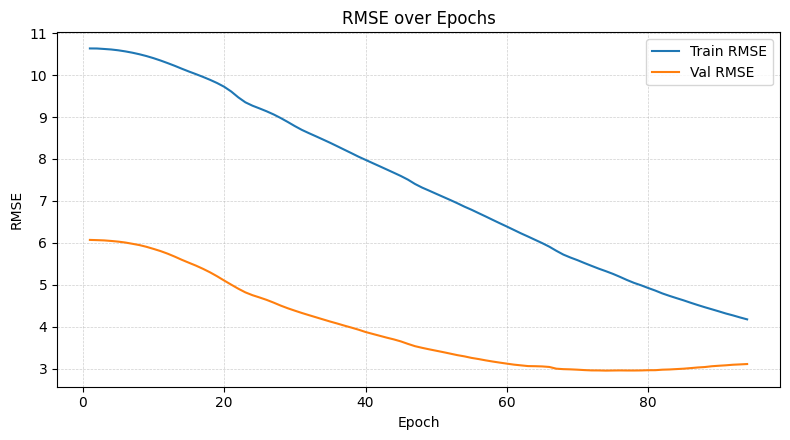

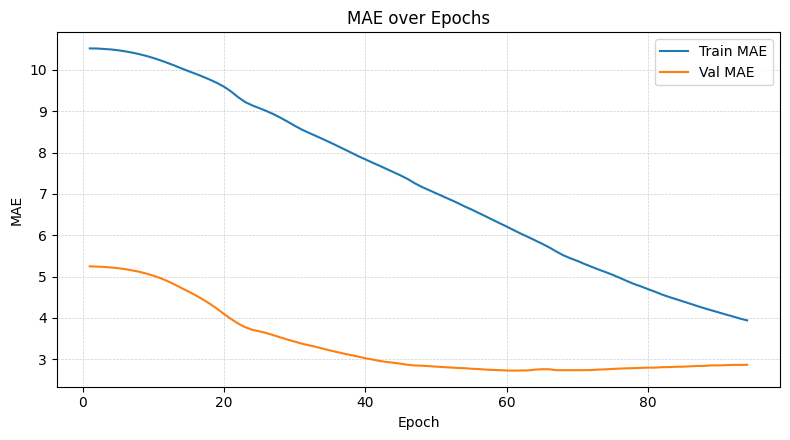

In [48]:
epochs_ran = range(1, len(epoch_hist["train_rmse"]) + 1)

# --- RMSE ---
plt.figure(figsize=(8, 4.5))
plt.plot(epochs_ran, epoch_hist["train_rmse"], label="Train RMSE")
plt.plot(epochs_ran, epoch_hist["val_rmse"],   label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("rmse_over_epochs.png", dpi=150)
plt.show()

# --- MAE ---
plt.figure(figsize=(8, 4.5))
plt.plot(epochs_ran, epoch_hist["train_mae"], label="Train MAE")
plt.plot(epochs_ran, epoch_hist["val_mae"],   label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE over Epochs")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("mae_over_epochs.png",  dpi=150)
plt.show()

In [49]:
_assert_cuda_4090(device)
grud_a = grud_a.to(device).eval()

# (Re)build a test loader. We reuse the same scale_shared used for train/val.
test_loader = make_loader(
    test_ix, shuffle=False,
    data=data, scale=scale, device=device,
    batch_size=256, prefer_full_batch=True, num_workers=0,
    return_prefetcher=False
)

In [51]:
# ===== GRUDA_Anchor — EVAL on TEST (ALL STREAMS) =====
grud_a.eval()

# (optional) ensure μ buffer is on the same device
with torch.no_grad():
    grud_a.x_global_mean = grud_a.x_global_mean.to(device)

test_preds, test_targs = [], []

with torch.no_grad():
    for batch in test_loader:
        (
            soil_b, soil_m_b, soil_d_b,
            indoor_b, indoor_m_b, indoor_d_b,
            weather_b, weather_m_b, weather_d_b,
            crop_b, crop_m_b, crop_d_b,              # unused by GRUDA baseline
            anchor_b, anchor_mask_b, anchor_delta_b, # used by GRUDA
            y_b
        ) = batch

        # --- ALL STREAMS: concat in the SAME order used in training ---
        x_b     = torch.cat([indoor_b,   soil_b,   weather_b],   dim=-1)
        mask_b  = torch.cat([indoor_m_b, soil_m_b, weather_m_b], dim=-1)
        delta_b = torch.cat([indoor_d_b, soil_d_b, weather_d_b], dim=-1)

        # move to device
        x_b     = x_b.to(device, non_blocking=True)
        mask_b  = mask_b.to(device, non_blocking=True)
        delta_b = delta_b.to(device, non_blocking=True)
        anchor_b= anchor_b.to(device, non_blocking=True)
        y_b     = y_b.to(device, non_blocking=True)

        # sanity check: feature count matches model.D
        assert x_b.size(-1) == grud_a.D, f"x_b D={x_b.size(-1)} but model.D={grud_a.D}"

        with autocast(device_type="cuda", dtype=amp_dtype):
            y_hat, _H = grud_a(
                x=x_b, mask=mask_b, delta=delta_b,
                anchor=anchor_b,
                return_seq=True, return_aux=False,
            )

        test_preds.append(y_hat)
        test_targs.append(y_b)

[GRUDA TEST] RMSE=2.939 | MAE=2.867


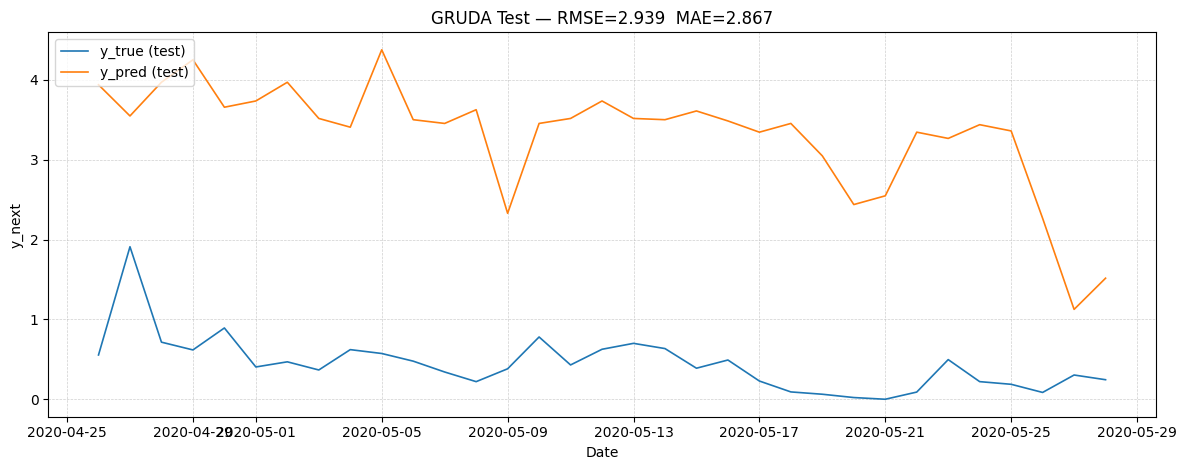

In [52]:
# stack & cast to float32 for metrics/numpy safety
test_preds_all = torch.cat(test_preds, dim=0).to(torch.float32)
test_targs_all = torch.cat(test_targs, dim=0).to(torch.float32)

# -------- metrics --------
test_mse  = F.mse_loss(test_preds_all, test_targs_all).item()
test_rmse = float(math.sqrt(test_mse))
test_mae  = F.l1_loss(test_preds_all, test_targs_all).item()
print(f"[GRUDA TEST] RMSE={test_rmse:.3f} | MAE={test_mae:.3f}")

# -------- plot y_true vs y_pred over time --------
y_true_np = test_targs_all.detach().cpu().numpy().reshape(-1)
y_pred_np = test_preds_all.detach().cpu().numpy().reshape(-1)

test_dates = pd.to_datetime(dates_np[test_ix])
plt.figure(figsize=(12, 4.8))
plt.plot(test_dates, y_true_np, label="y_true (test)", linewidth=1.2)
plt.plot(test_dates, y_pred_np, label="y_pred (test)", linewidth=1.2)
plt.title(f"GRUDA Test — RMSE={test_rmse:.3f}  MAE={test_mae:.3f}")
plt.xlabel("Date"); plt.ylabel("y_next")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("GRUDA_Test_vs_Pred.png", dpi=150)
plt.show()